# Rossmann Sales Prediction

## 0. Importação de Bibliotecas e *Helper Functions*

In [3]:
import math
import pickle
import random
import warnings
import inflection
import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb
from scipy                 import stats
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from IPython.core.display  import HTML
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

In [5]:
def personal_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['font.size'] = 20
    display(HTML('<style>.container{width:90% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x:'%.2f' % x)
    sns.set()
    sns.set(rc = {'figure.figsize':(15,8)})
    warnings.filterwarnings('ignore')

personal_settings()

In [3]:
def cramer_v(x, y):
    '''Função para verificar a correlação entre as variáveis categóricas'''
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    v = np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr-1)))
    
    return v

def mean_absolute_percentage_error(y, yhat):
    '''Função para cálculo do MAPE dos modelos de Machine Learning'''
    return np.mean(np.abs((y - yhat) / y))

def mean_percentage_error(y, yhat):
    '''Função para o cálculo do MPE dos modelos de Machine Learning'''
    return np.mean((y - yhat) / y)

def ml_error(model_name, y, yhat):
    '''Função para cálculo do MAE, MAPE e RMSE dos modelos de Machine Learning'''
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    '''Função para realizar o Cross Validation dos modelos de Machine Learning'''
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # data de início e final para validação
        val_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        val_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtrando conjunto de dados
        training = x_training[x_training['date'] < val_start_date]
        validation = x_training[(x_training['date'] >= val_start_date) & (x_training['date'] <= val_end_date)]
        
        # conjunto de dados de treino
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        
        # conjunto de dados de validação
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']
        
        # modelo
        m = model.fit(xtraining, ytraining)
        
        # previsão
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # armazenando as métricas de performance
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
        # retornando dataframe com a média +/- o desvio padrão das métricas de performance
        df = pd.DataFrame({'Model Name': model_name,
                           'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                           'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                           'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])
        
    return df

## 1. Carregando os Dados

In [7]:
df_sales_raw = pd.read_csv('csv/train.csv', low_memory=False)
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
df_stores_raw = pd.read_csv('csv/store.csv', low_memory=False)
df_stores_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


In [9]:
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


## 2. Descrição dos Dados

In [10]:
df1 = df_raw.copy()

### 2.1 Renomeando Colunas

Aqui simplesmente vou formatar os nomes das colunas em letras minúsculas e separadas por '_'.

In [11]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

to_snakecase = lambda x: inflection.underscore(x)

new_cols = list(map(to_snakecase, old_cols))

In [12]:
df1.columns = new_cols
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 2.2 Dicionário de Colunas

- store: id único para cada loja
- day_of_week: dia da semana (1 a 7)
- date: data
- sales: o volume de vendas no dia
- customers: o número de clientes no dia
- open: indicador se a loja estava aberta ou não (0 = fechada | 1 = aberta)
- promo: indica se a loja estava com alguma promoção no dia
- state_holiday: indica se era feriado estadual/nacional no dia (a = feriado público | b = Páscoa | c = Natal | 0 = nenhum)
- school_holiday: indica se a loja no dia foi afetada pelo fechamento das escolas públicas
- store_type: indica o tipo da loja (4 tipos: a, b, c, d)
- assortment: descreve o nível de mix de produtos (a = básico | b = extra | c = extenso)
- competition_distance: distância em metros para a loja do concorrente mais próxima
- competition_open_since_month: mês que a loja do concorrente mais próxima foi aberta 
- competition_open_since_year: ano que a loja do concorrente mais próxima foi aberta
- promo2: promoção contínua e consecutiva para algumas lojas (0 = loja não participou | 1 = loja participou)
- promo2_since_week: indica a semana do ano que a loja começou a participar da promo2
- promo2_since_year: indica o ano que a loja começou a participar da promo2 (complementar à promo2_since_week)
- promo_interval: descreve os intervalos consecutivos que a promo2 começou, indicando os meses que a promoção começou novamente (Ex.: "Feb,May,Aug,Nov" significa que cada intervalo começou em Fevereiro, Maio, Agosto e Novembro em determinado ano para determinada loja)

### 2.3 Dimensões

In [13]:
print(f'Número de atributos/colunas: {df1.shape[1]}')
print(f'Número de registros/linhas:  {df1.shape[0]}')

Número de atributos/colunas: 18
Número de registros/linhas:  1017209


### 2.4 Tipos de Dados

In [14]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

### 2.5 Alterando Tipos de Dados

Vou alterar o tipo de dado da coluna *date* para data.

In [15]:
display(df1['date'].head())
display(df1['date'].dtypes)

0    2015-07-31
1    2015-07-31
2    2015-07-31
3    2015-07-31
4    2015-07-31
Name: date, dtype: object

dtype('O')

In [16]:
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d')

In [17]:
display(df1['date'].head())
display(df1['date'].dtypes)

0   2015-07-31
1   2015-07-31
2   2015-07-31
3   2015-07-31
4   2015-07-31
Name: date, dtype: datetime64[ns]

dtype('<M8[ns]')

### 2.6 Valores Nulos

In [18]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 2.7 Preenchendo Valores Nulos

Vou optar por preencher os valores nulos ao invés de removê-los pelo fato de que estaria removendo um número grande de registros, o que iria prejudicar a análise e a performance dos modelos de Machine Learning.

#### competition_distance

A coluna indica a distância em metros para a loja do concorrente mais próxima.

Se o valor da coluna é nulo, podemos presumir que:
- Não existe uma loja do concorrente por perto; ou
- A loja do concorrente está muito longe. 

Para preencher os valores nulos, irei colocar uma distância muito grande, indicando que não existem lojas concorrentes próximas.

In [19]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#### competition_open_since_month & competition_open_since_year

As colunas indicam o mês e o ano que a loja do concorrente mais próxima foi aberta.

Se o valor da coluna é nulo, podemos presumir que:
- Não existe loja do concorrente por perto; ou 
- A loja do concorrente é tão antiga que não sabemos quando ela abriu.

Para preenchermos os valores nulos, vamos utilizar o mês e ano da coluna *date*, já pensando na etapa posterior de *feature engineering* (criação de novas variáveis).

Se uma loja não tem concorrentes por perto, a quantidade de vendas tende a ser maior. 

Quando existe uma loja do concorrente por perto, a quantidade de vendas tende a ser menor, vez que irá compartilhar clientes.

Mas, depois de certo tempo, essa loja que tem um concorrente próximo, tende a ter um leve crescimento de vendas, já que o concorrente deixa de ser 'novidade'. 

Então, o tempo que um concorrente próximo surgiu é um fator que influencia o aumento ou queda de vendas de uma loja.

Por isso vou manter essas colunas e substituir os valores nulos pelo mês e ano da coluna *date*.

In [20]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

In [21]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#### promo2_since_week & promo2_since_year

As colunas indicam a semana do ano e o ano que a loja começou a participar da *promo2*.

Se o valor da coluna é nulo, indica que a loja não participou da *promo2*.

Seguindo com a lógica anterior, vou manter essas colunas e substituir os valores nulos pela semana do ano e ano da coluna *date*.

In [22]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

In [23]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#### promo_interval

A coluna descreve os intervalos consecutivos que a promo2 começou, indicando os meses que a promoção começou novamente (Ex.: "Feb,May,Aug,Nov" significa que cada intervalo começou em Fevereiro, Maio, Agosto e Novembro em determinado ano para determinada loja).

Para preencher os valores nulos, vou verificar se no mês constante da coluna *date* a loja estava no período da promo2.

Para indicar se a loja estava com promoção na data constante na coluna *date*, vou criar a coluna *is_promo*, onde o valor 0 indica que não, e o valor 1 indica que sim.

In [24]:
months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 7: 'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

In [25]:
df1['promo_interval'] = df1['promo_interval'].fillna(0)

In [26]:
df1['month'] = df1['date'].dt.month.map(months)

In [27]:
df1['is_promo'] = df1[['promo_interval', 'month']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month'] in x['promo_interval'].split(',') else 0, axis = 1)

Verificando novamente os valores nulos por variável, todos foram devidamente preenchidos:

In [28]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month                           0
is_promo                        0
dtype: int64

### 2.8 Análise Estatística Descritiva

#### Alterando Tipos de Dados

In [29]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month                                   object
is_promo                                 int64
dtype: object

In [30]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week']            = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year']            = df1['promo2_since_year'].astype('int64')

In [31]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month                                   object
is_promo                                 int64
dtype: object

#### Atributos Numéricos

In [32]:
df_numerical = df1.select_dtypes(include = ['int64', 'float64'])
df_numerical.sample()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
195804,680,5,5106,745,1,1,0,170.00,2,2015,1,35,2012,0


In [33]:
df_numerical = df_numerical.drop(['store', 'open', 'promo', 'school_holiday', 'promo2', 'is_promo'], axis = 1)

In [34]:
df_numerical.sample()

,day_of_week,sales,customers,competition_distance,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year
486372,2,9534,1271,140.00,9,2012,17,2014


In [35]:
df_mean     = pd.DataFrame(df_numerical.apply(np.mean)).T
df_median   = pd.DataFrame(df_numerical.apply(np.median)).T
df_std      = pd.DataFrame(df_numerical.apply(np.std)).T
df_min      = pd.DataFrame(df_numerical.apply(min)).T
df_max      = pd.DataFrame(df_numerical.apply(max)).T
df_range    = pd.DataFrame(df_numerical.apply(lambda x: x.max() - x.min())).T
df_skew     = pd.DataFrame(df_numerical.apply(lambda x: x.skew())).T
df_kurtosis = pd.DataFrame(df_numerical.apply(lambda x: x.kurtosis())).T

In [36]:
df_desc = pd.concat([df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis]).T.reset_index()
df_desc.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
df_desc

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
1,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
2,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
3,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
4,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
5,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07
6,promo2_since_week,1.00,52.00,51.00,23.62,22.00,14.31,0.18,-1.18
7,promo2_since_year,2009.00,2015.00,6.00,2012.79,2013.00,1.66,-0.78,-0.21


#### Atributos Categóricos

In [37]:
df_cat = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])
df_cat.sample()

,state_holiday,store_type,assortment,promo_interval,month
638074,0,a,a,"Jan,Apr,Jul,Oct",Dec


In [38]:
mask1 = df1['state_holiday'] != '0'
mask2 = df1['sales'] > 0

df_aux1 = df1[mask1 & mask2]

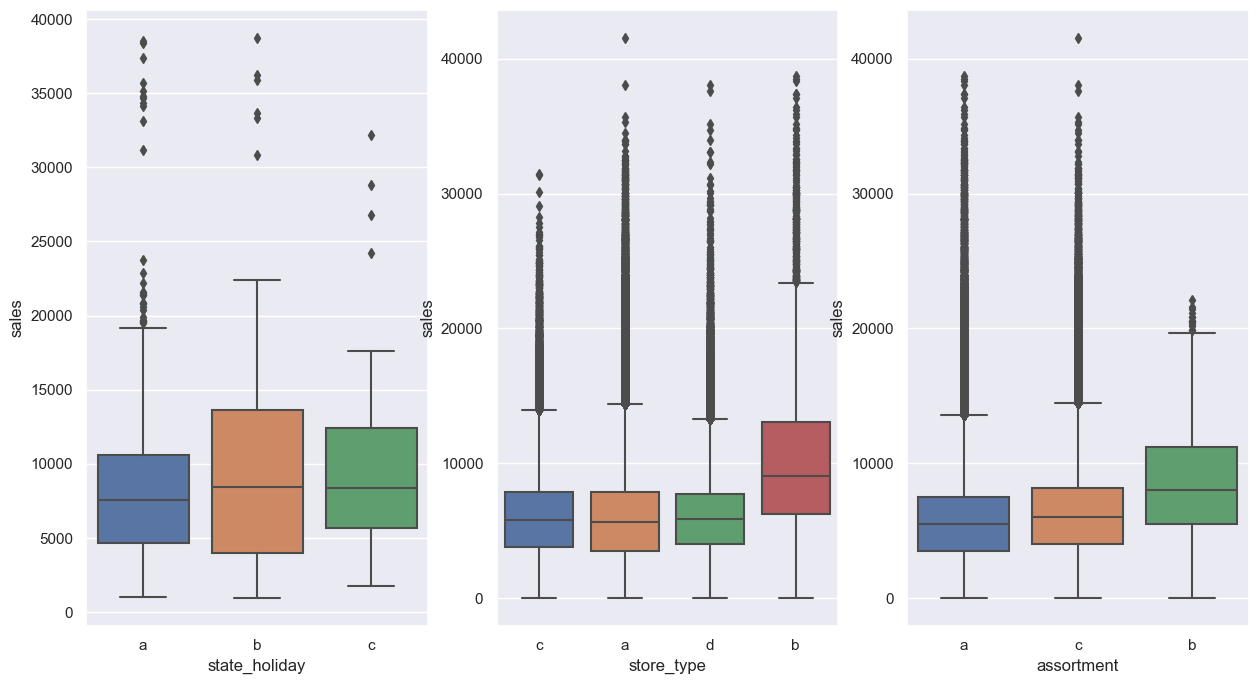

In [39]:
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=df_aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=df1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=df1);

## 3. Criação de Variáveis - *Feature Engineering*

### 3.1 *Mindmap* de Hipóteses

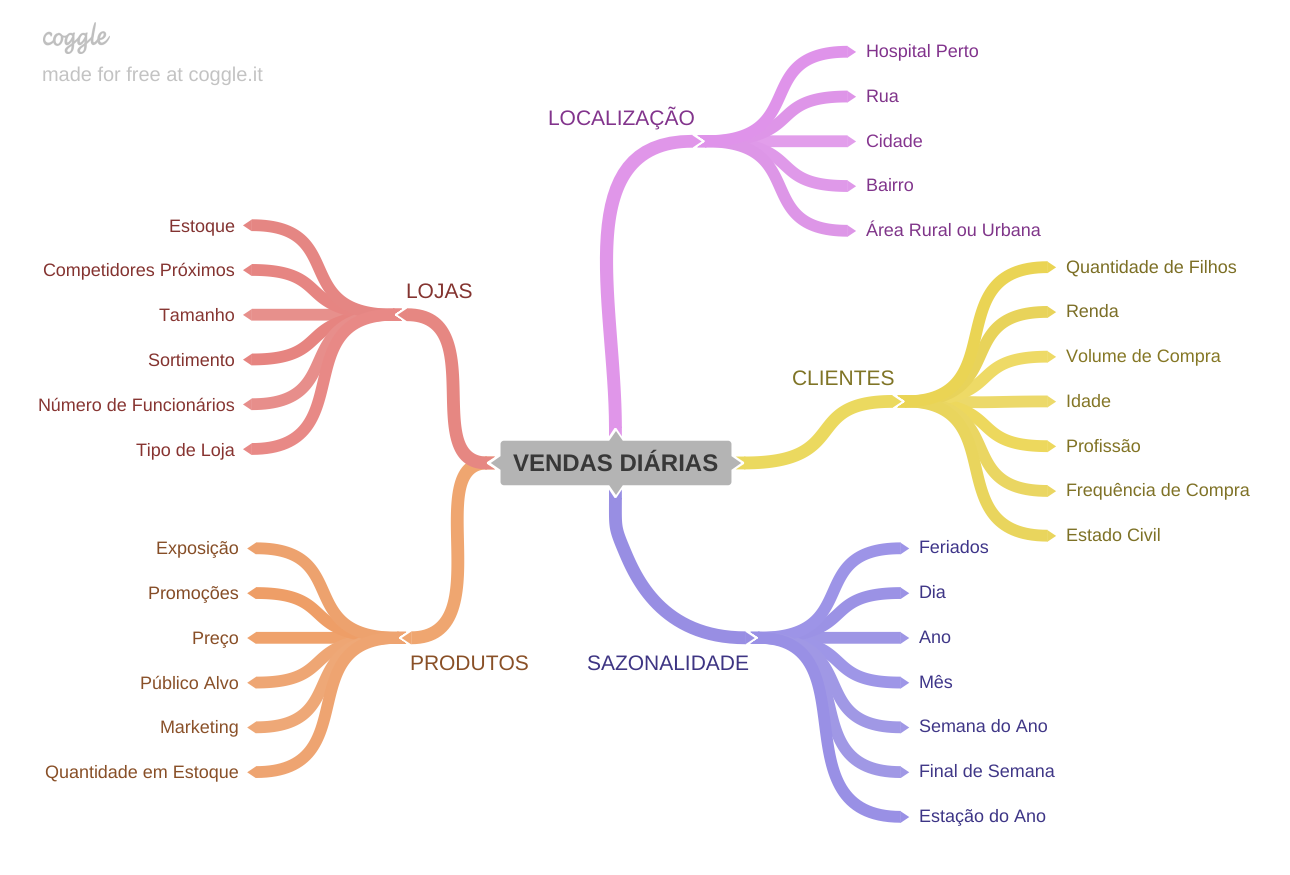

In [37]:
Image('images/mindmap_rossmann.png')

O fenômeno que estou observando são as vendas diárias feitas pelas lojas da Rossmann. 

Assim, listei como agentes que afetam esse fenômeno as próprias lojas, os produtos, os clientes, a localização e a sazonalidade. 

Para cada um desses agentes, listei alguns atributos que servirão de base para levantamento e validação de hipóteses. 

### 3.2 Lista de Hipóteses

Diante do *mindmap* elaborado, podemos elaborar várias hipóteses de como os agentes e seus atributos afetam o fenômeno de vendas diárias. 

Contudo, irei me limitar às hipóteses que podem ser validadas (ou não) com base nos dados que já temos disponíveis.

- Lojas:
    - Lojas com maior sortimento (mix de produtos) vendem mais;
    - Lojas com competidores muito próximos vendem menos;
    - Lojas com competidores a mais tempo vendem menos;
- Produtos:
    - Lojas com promoções ativas por mais tempo vendem mais;
    - Lojas com mais promoções consecutivas vendem mais;
- Sazonalidade:
    - Lojas abertas durante o feriado de Natal vendem mais;
    - Lojas vendem cada vez mais ao longo dos anos;
    - Lojas vendem mais no segundo semestre do ano;
    - Lojas vendem mais depois do dia 10 de cada mês;
    - Lojas vendem menos no final de semana;
    - Lojas vendem menos durante feriados escolares;

### 3.3 Criação de Variáveis/*Features*

Diante das hipóteses levantadas, preciso criar novas colunas/variáveis para conseguir analisá-las.

In [40]:
df2 = df1.copy()

#### *year*

In [41]:
df2['year'] = df2['date'].dt.year

#### *month*

In [42]:
df2['month'] = df2['date'].dt.month

#### *day*

In [43]:
df2['day'] = df2['date'].dt.day

#### *week of year*

In [44]:
df2['week_of_year'] = df2['date'].dt.weekofyear

#### *year week*

In [45]:
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#### *competition_open_time_month*

In [46]:
df2['competition_open_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

In [47]:
df2['competition_open_time_month'] = ((df2['date'] - df2['competition_open_since']) / 30).apply(lambda x: x.days).astype(int)

#### *promo_since_week*

In [48]:
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

In [49]:
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

In [50]:
df2['promo_since_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

#### *assortment*

In [51]:
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#### *state_holiday*

In [52]:
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

#### Verificando as novas variáveis/*features*

In [53]:
df2.sample(5).T

,777684,284023,957553,992834,521013
store,200,1066,554,155,1094
day_of_week,6,2,6,2,6
date,2013-08-03 00:00:00,2014-11-11 00:00:00,2013-02-23 00:00:00,2013-01-22 00:00:00,2014-03-22 00:00:00
sales,6701,11356,3033,6653,5217
customers,853,1084,316,613,433
open,1,1,1,1,1
promo,0,1,0,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,a,a,c,d,d


## 4. Filtragem de Variáveis

In [54]:
df3 = df2.copy()

### 4.1 Filtragem das Linhas

Não vou manter as linhas em que a coluna *open* indique que a loja estava fechada - isso porque com a loja fechada as vendas serão 0.

Da mesma forma, não vou manter as linhas em que a coluna *sales* for igual a 0 também.

In [55]:
mask1 = df3['open'] != 0
mask2 = df3['sales'] > 0

df3 = df3[mask1 & mask2]

### 4.2 Seleção das Colunas

A coluna *customers* é uma coluna que não terei como prever no futuro - seria necessário fazer um modelo para prever a quantidade de clientes que irão na loja nas próximas semanas - então vou remover ela. 

Ainda, vou remover a coluna *open* já que todas as linhas que restaram indicam que as lojas estão abertas, e também removerei a coluna *promo_interval*.

In [56]:
cols_to_drop = ['customers', 'open', 'promo_interval']
df3 = df3.drop(cols_to_drop, axis = 1)

In [57]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,month,is_promo,year,day,week_of_year,year_week,competition_open_since,competition_open_time_month,promo_since,promo_since_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.00,9,2008,0,31,2015,7,0,2015,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.00,11,2007,1,13,2010,7,1,2015,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.00,12,2006,1,14,2011,7,1,2015,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.00,9,2009,0,31,2015,7,0,2015,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.00,4,2015,0,31,2015,7,0,2015,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5. Análise Exploratória de Dados

In [58]:
df4 = df3.copy()

### 5.1 Análise Univariada

#### Variável Resposta

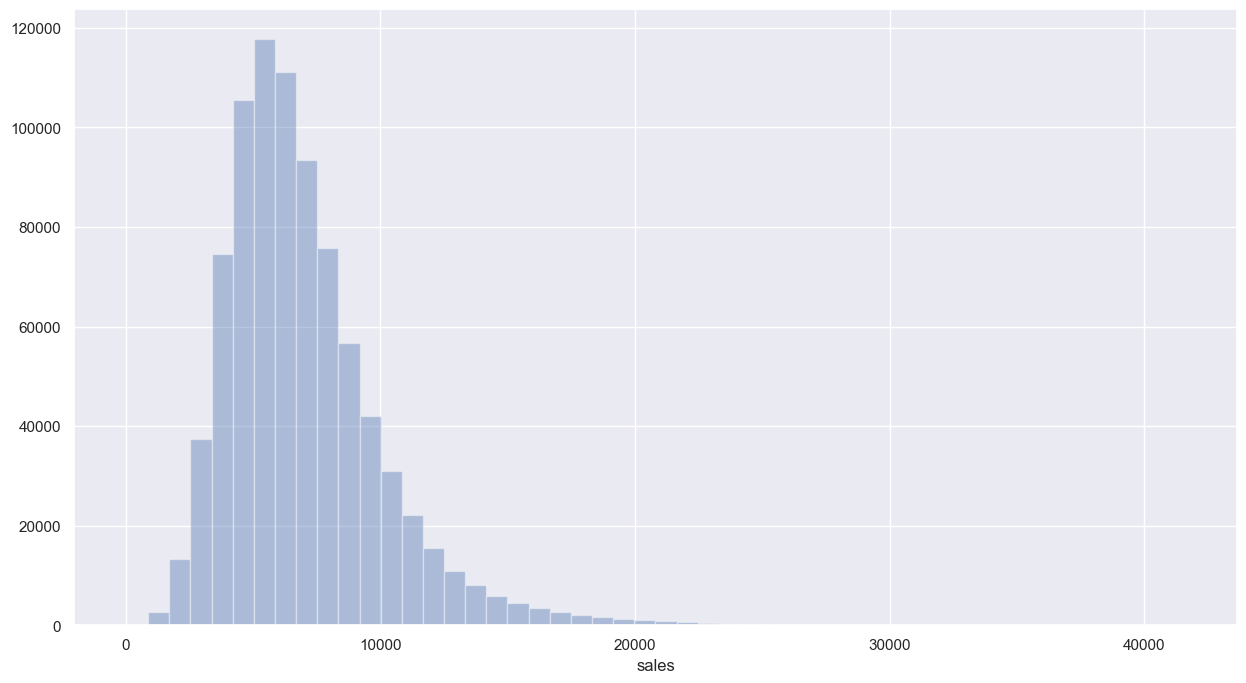

In [57]:
sns.distplot(df4['sales'], kde=False);

#### Variáveis Numéricas

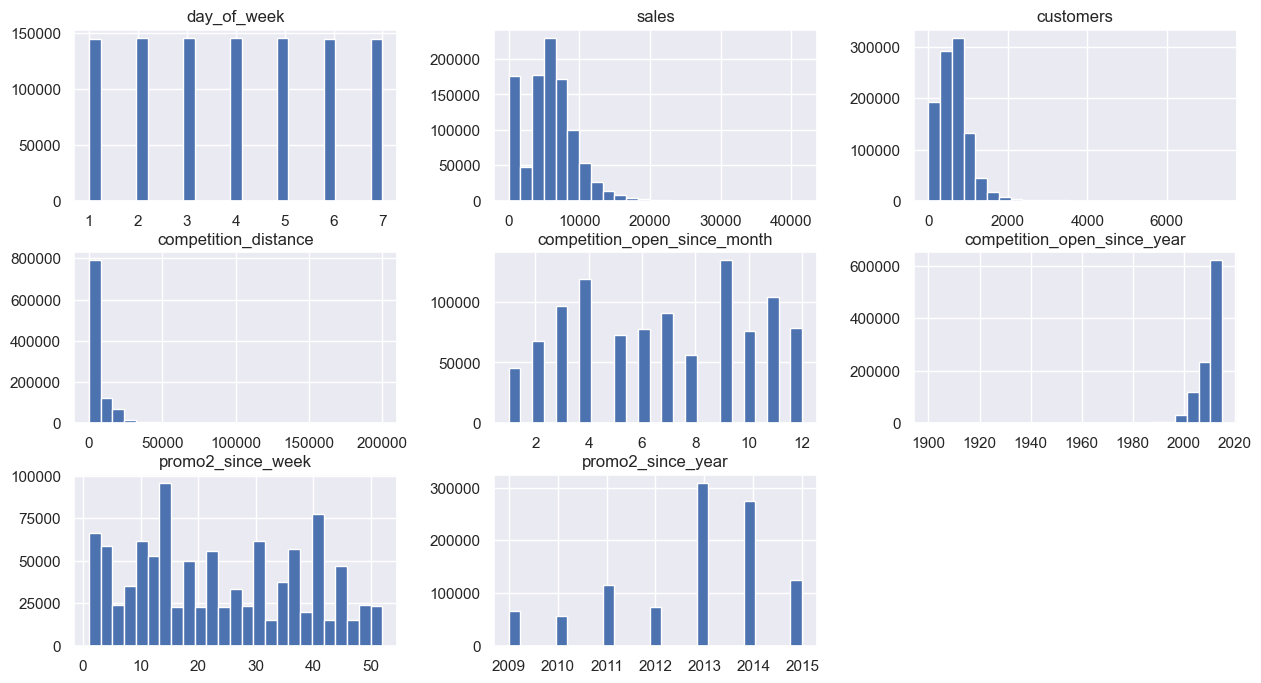

In [58]:
df_numerical.hist(bins = 25);

#### Variáveis Categóricas

In [59]:
df_cat.sample(1)

,state_holiday,store_type,assortment,promo_interval,month
250123,0,a,a,"Feb,May,Aug,Nov",Dec


##### state_holiday

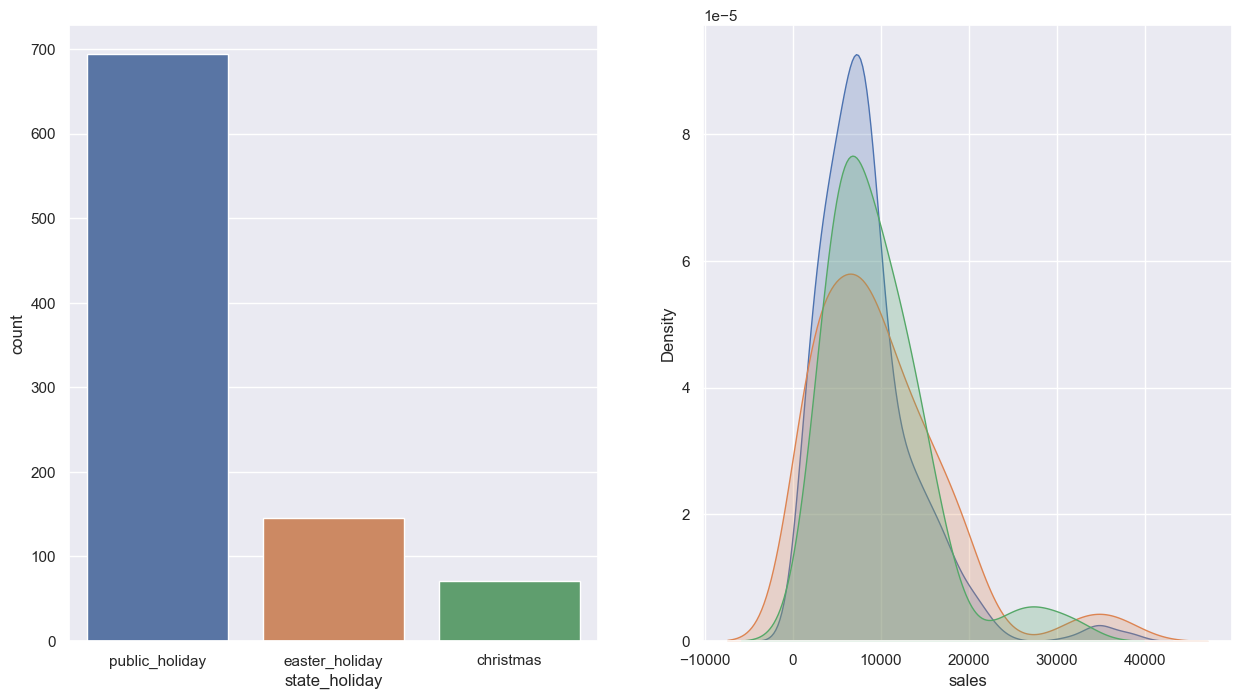

In [63]:
plt.subplot(1, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True);

##### store_type

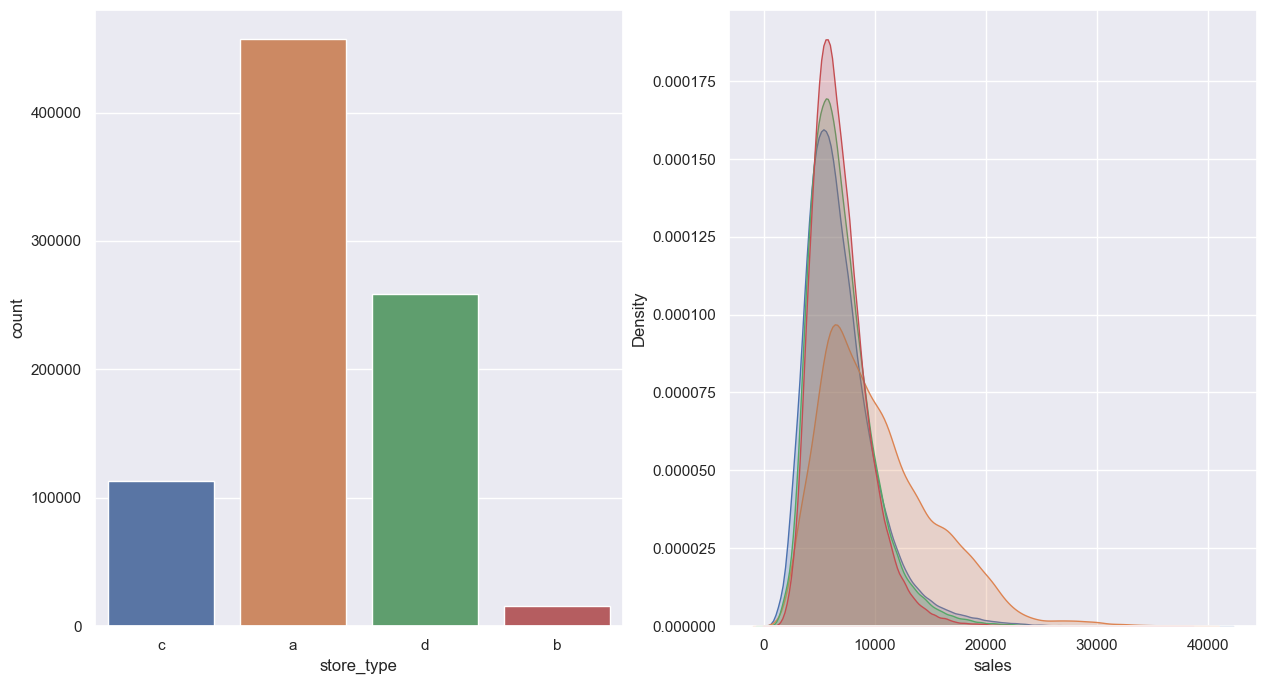

In [64]:
plt.subplot(1, 2, 1)
sns.countplot(x=df4['store_type'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);

##### assortment

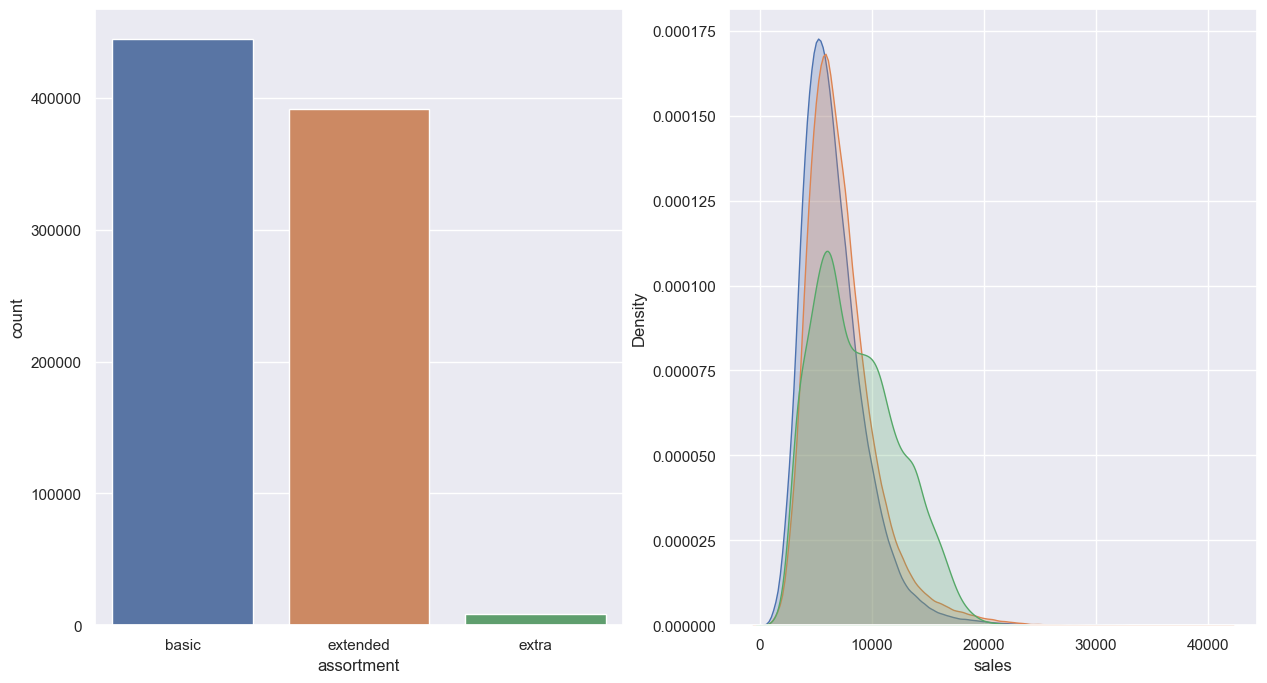

In [65]:
plt.subplot(1, 2, 1)
sns.countplot(x=df4['assortment'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

### 5.2 Análise Bivariada - Validação de Hipóteses

#### H1. Lojas com maior sortimento (mix de produtos), na média, vendem mais

**VERDADEIRA**: Lojas com maior sortimento (mix de produtos), na média, vendem mais em comparação a lojas com menor sortimento. 

Chamo a atenção para o fato de que existem muito menos lojas com maior sortimento do que lojas com menor sortimento.

In [66]:
assortment_sales = df4[['assortment', 'sales']].groupby('assortment')
assortment_sales = assortment_sales.agg(
    total_sales = pd.NamedAgg('sales', 'mean'),
    qty = pd.NamedAgg('assortment', 'count')).reset_index()
assortment_sales

,assortment,total_sales,qty
0,basic,6621.52,444875
1,extended,7300.84,391254
2,extra,8642.50,8209


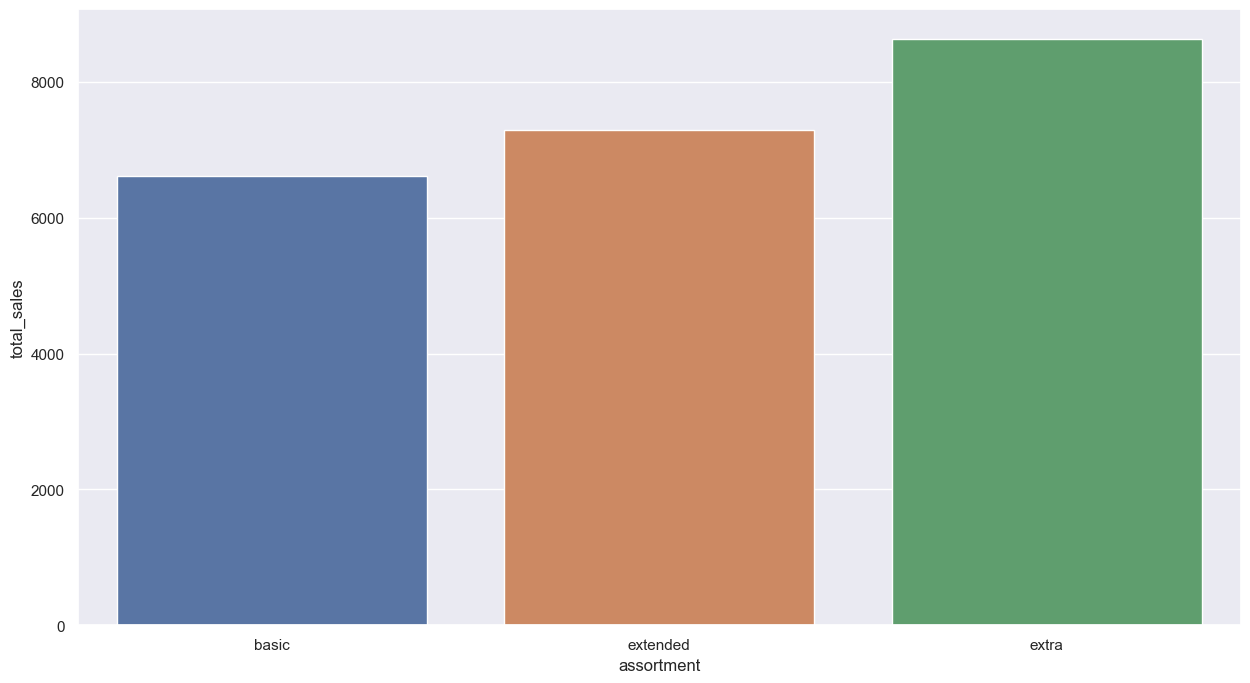

In [67]:
sns.barplot(x='assortment', y='total_sales', data=assortment_sales);

#### H2. Lojas com competidores muito próximos vendem menos

**FALSA**: Lojas com competidores muito próximos (até 1000m) vendem mais em comparação a lojas com competidores mais distantes. 

In [68]:
comp_close = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
comp_close.head()

,competition_distance,sales
0,20.00,4579807
1,30.00,17552666
2,40.00,29261626
3,50.00,60835848
4,60.00,22088359


In [69]:
bins = list(np.arange(0, 20000, 1000))
comp_close['competition_distance_grouped'] = pd.cut(comp_close['competition_distance'], bins=bins)

In [74]:
comp_close2 = comp_close[['competition_distance_grouped', 'sales']].groupby('competition_distance_grouped').sum().reset_index()
comp_close2.head()

,competition_distance_grouped,sales
0,"(0, 1000]",1832415839
1,"(1000, 2000]",918682669
2,"(2000, 3000]",610405362
3,"(3000, 4000]",378745560
4,"(4000, 5000]",325665741


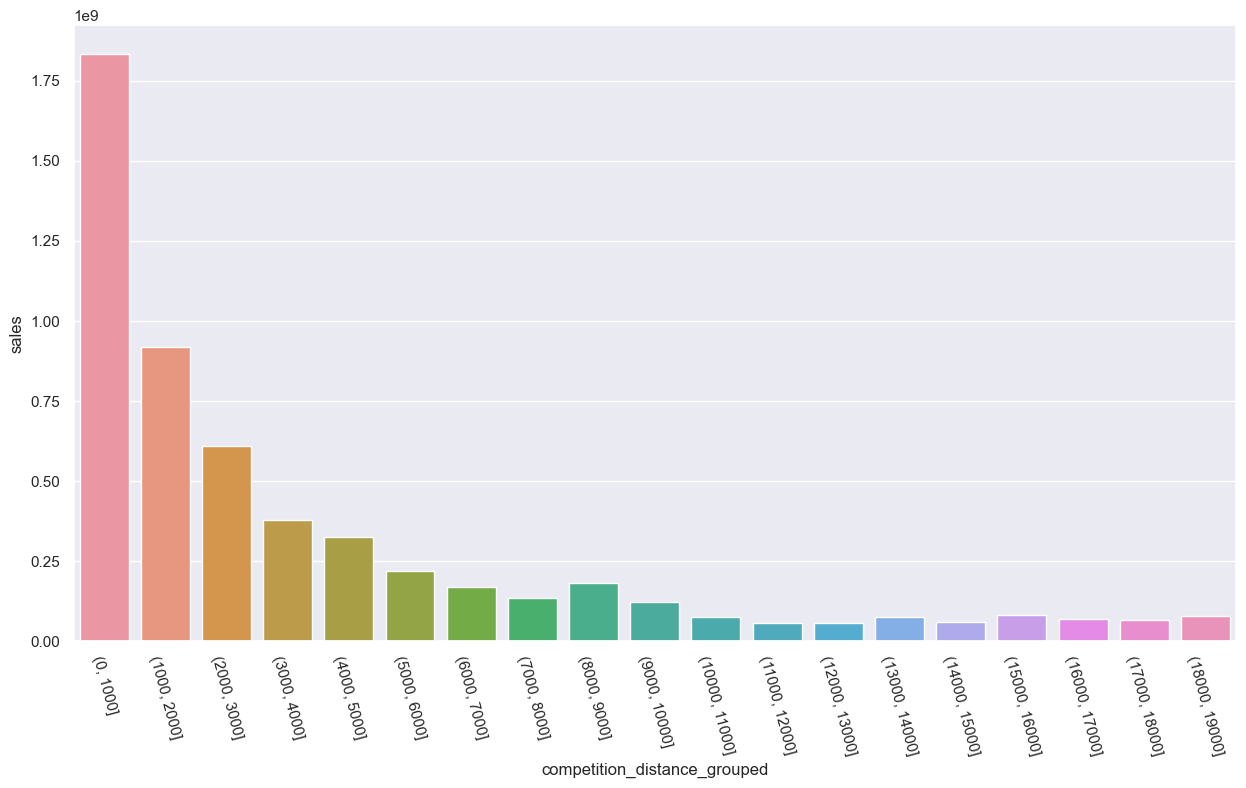

In [75]:
sns.barplot(x='competition_distance_grouped', y='sales', data=comp_close2)
plt.xticks(rotation=-75);

##### Verificando a correlação com a variável resposta

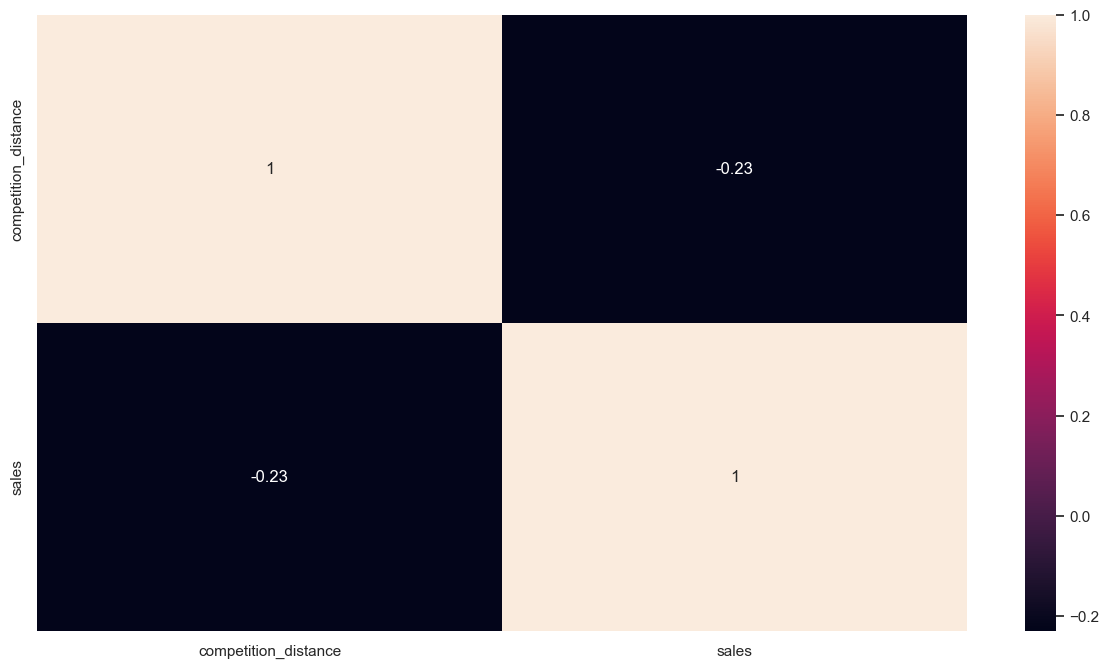

In [87]:
sns.heatmap(comp_close.corr(method='pearson'), annot=True);

#### H3. Lojas com competidores a mais tempo vendem menos

**VERDADEIRA**: Lojas com competidores a mais tempo vendem menos em comparação com lojas com competidores mais recentes.

In [79]:
comp_old = df4[['competition_open_time_month', 'sales']].groupby('competition_open_time_month').sum().reset_index()
comp_old.sample(5)

,competition_open_time_month,sales
283,252,261005
196,164,5903015
95,63,23918905
29,-3,33018701
23,-9,22802012


In [80]:
comp_old_aux = comp_old[(comp_old['competition_open_time_month'] > 0) & (comp_old['competition_open_time_month'] < 360)]
comp_old_aux.tail()

,competition_open_time_month,sales
312,302,899127
313,303,915938
314,304,900754
315,305,588583
316,306,156663


In [81]:
bins = list(np.arange(0, 313, 12))
comp_old_aux['competition_open_time_month_grouped'] = pd.cut(comp_old_aux['competition_open_time_month'], bins=bins)

comp_old_aux2 = comp_old_aux[['competition_open_time_month_grouped', 'sales']].groupby('competition_open_time_month_grouped').sum().reset_index()
comp_old_aux2.tail()

,competition_open_time_month_grouped,sales
21,"(252, 264]",0
22,"(264, 276]",2182885
23,"(276, 288]",10347728
24,"(288, 300]",10968843
25,"(300, 312]",4362770


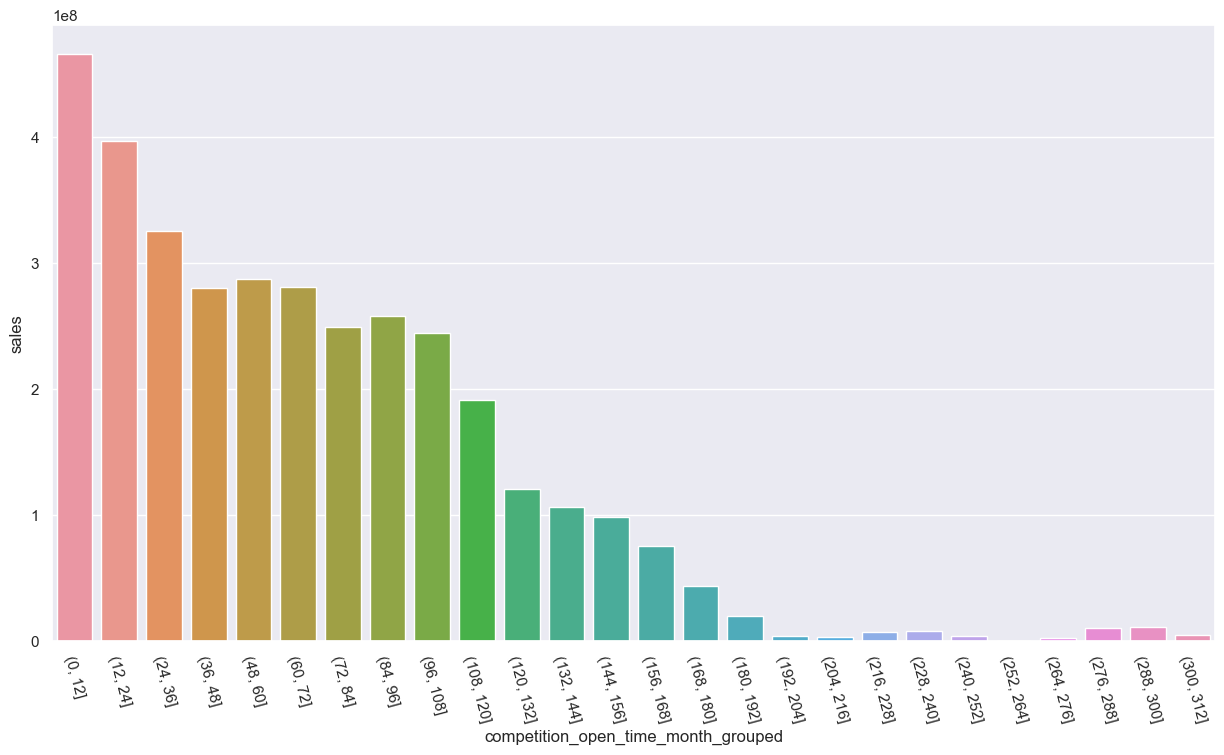

In [82]:
sns.barplot(x='competition_open_time_month_grouped', y='sales', data=comp_old_aux2)
plt.xticks(rotation=-75);

##### Verificando a correlação com a variável resposta

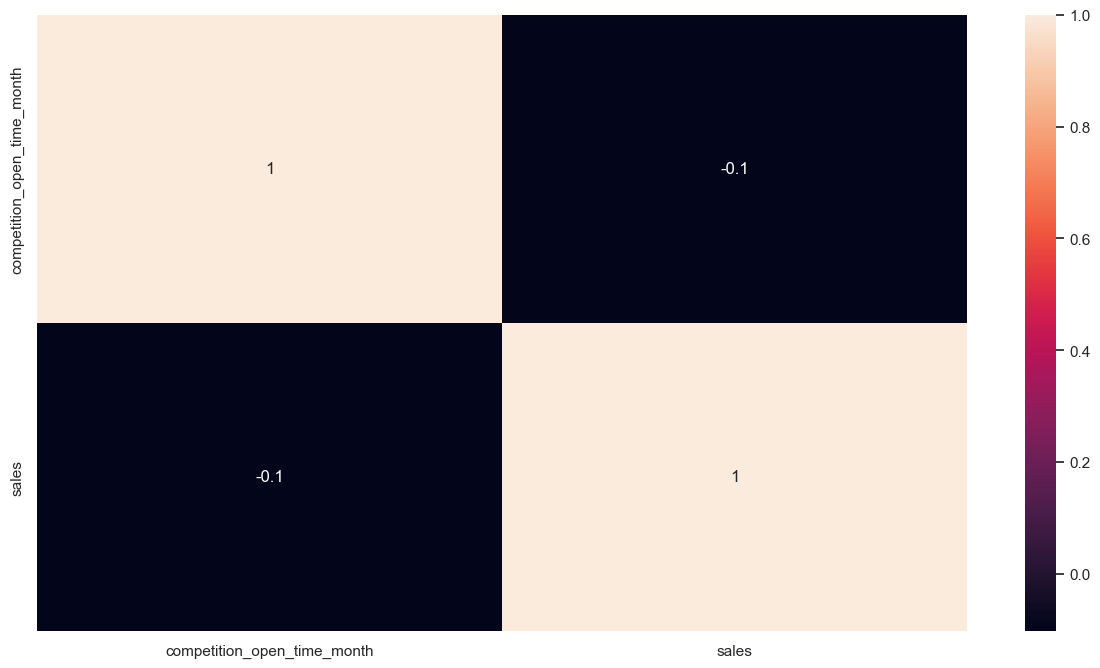

In [88]:
sns.heatmap(comp_old.corr(method='pearson'), annot=True);

#### H4. Lojas com promoções ativas por mais tempo vendem mais

**FALSA**: Lojas com promoções ativas por mais tempo vendem menos depois de um determinado período de promoção.

In [84]:
promo_time = df4[['promo_since_week', 'sales']].groupby('promo_since_week').sum().reset_index()
promo_time.sample(5)

,promo_since_week,sales
196,70,9809009
237,111,9807626
424,298,2506865
254,128,10579069
109,-17,6274935


Aqui, importante destacar que valores negativos representam que as vendas foram feitas antes do período de promoção estendida (promo2) mas durante o período de promoção regular, enquanto que valores positivos representam que as vendas foram feitas durante o período de promoção estendida (promo2).

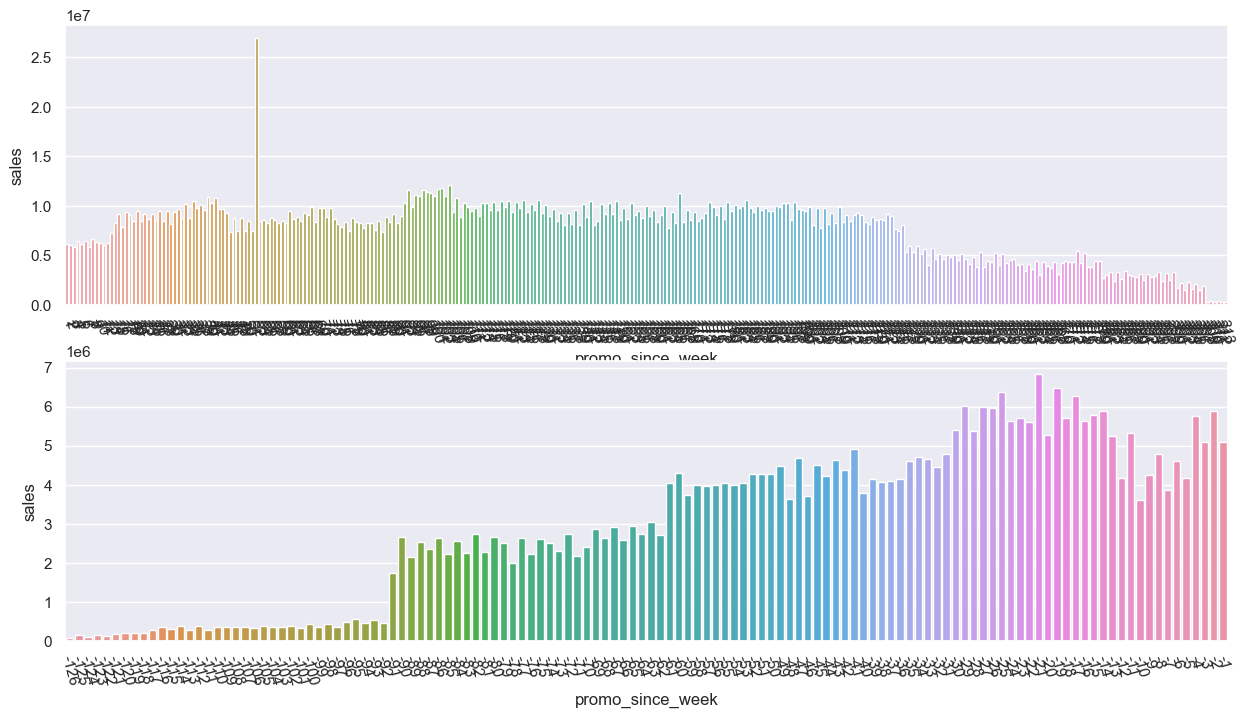

In [85]:
plt.subplot(2, 1, 1)
promo_time_aux = promo_time[promo_time['promo_since_week'] > 0]
sns.barplot(x='promo_since_week', y='sales', data=promo_time_aux)
plt.xticks(rotation=-75)

plt.subplot(2, 1, 2)
promo_time_aux1 = promo_time[promo_time['promo_since_week'] < 0]
sns.barplot(x='promo_since_week', y='sales', data=promo_time_aux1)
plt.xticks(rotation=-75);

##### Verificando a correlação com a variável resposta

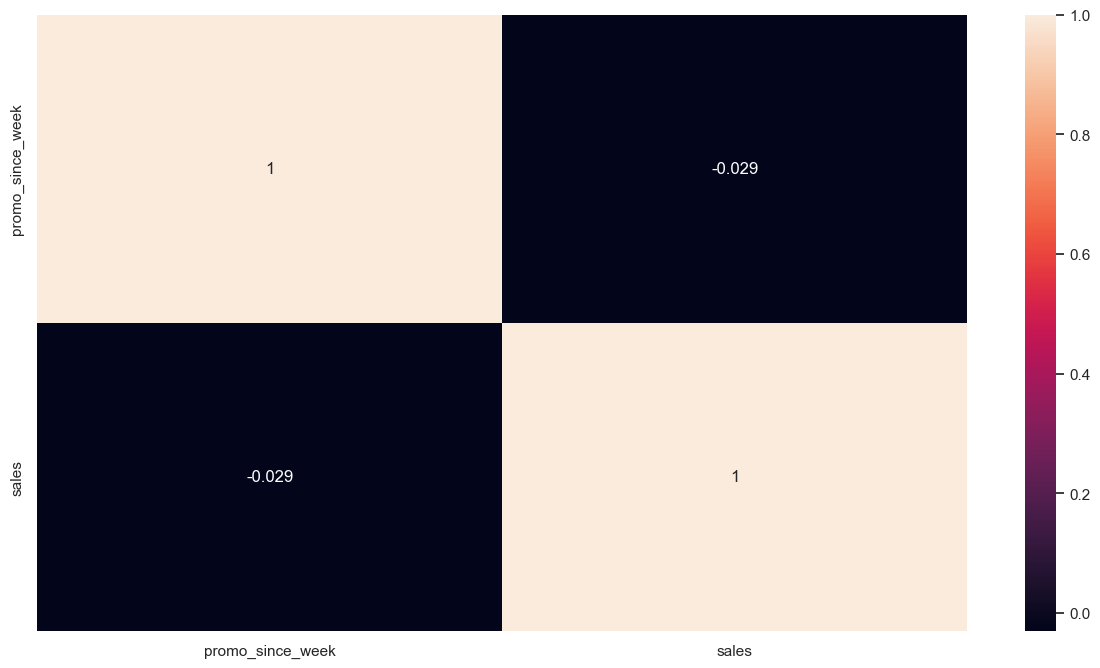

In [90]:
sns.heatmap(promo_time.corr(method='pearson'), annot=True);

#### H5. Lojas com mais promoções consecutivas vendem mais

**FALSA**: Lojas com mais promoções consecutivas acabam vendendo menos

In [91]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values('sales', ascending=False).reset_index()

,promo,promo2,sales
0,1,0,1628930532
1,0,0,1482612096
2,1,1,1472275754
3,0,1,1289362241


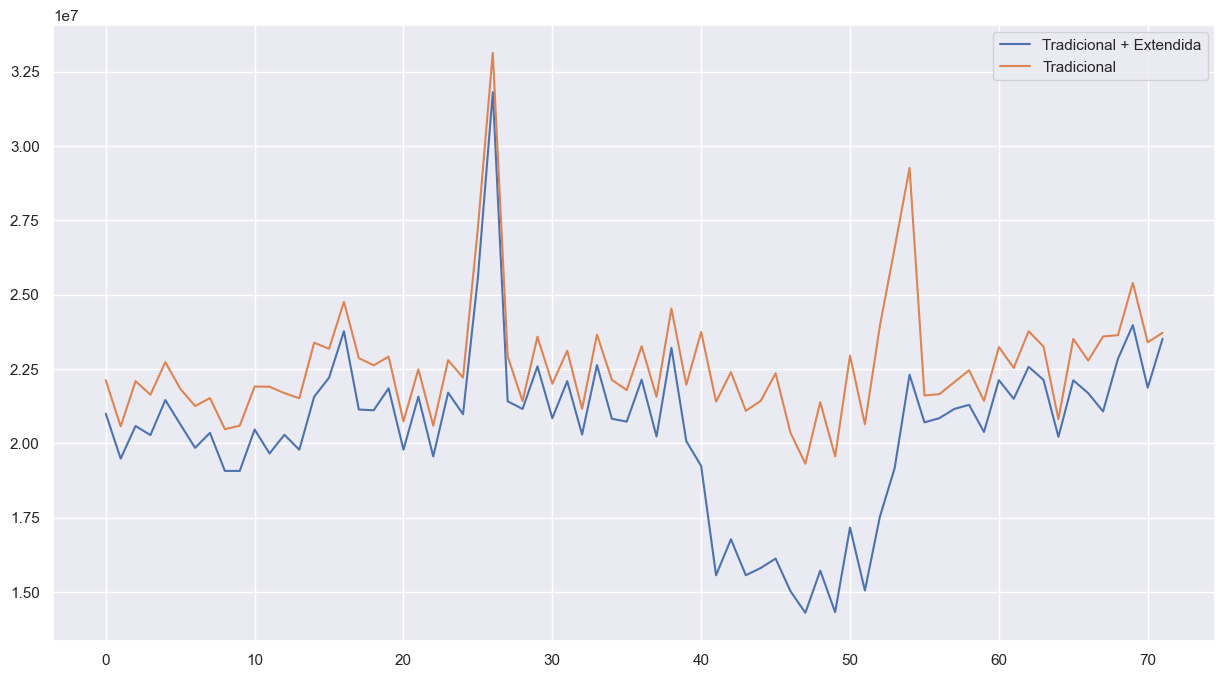

In [92]:
promos = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = promos.plot()

only_promo = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
only_promo.plot(ax=ax)

ax.legend(labels=['Tradicional + Extendida', 'Tradicional']);

#### H6. Lojas abertas durante o feriado de Natal vendem mais

**FALSA**: Mesmo levando em conta que *public_holiday* engloba mais de um feriado, as lojas abertas durante o feriado de Natal vendem até menos do que as lojas abertas durante o feriado de Páscoa.

In [93]:
df_aux = df4[df4['state_holiday'] != 'regular_day']

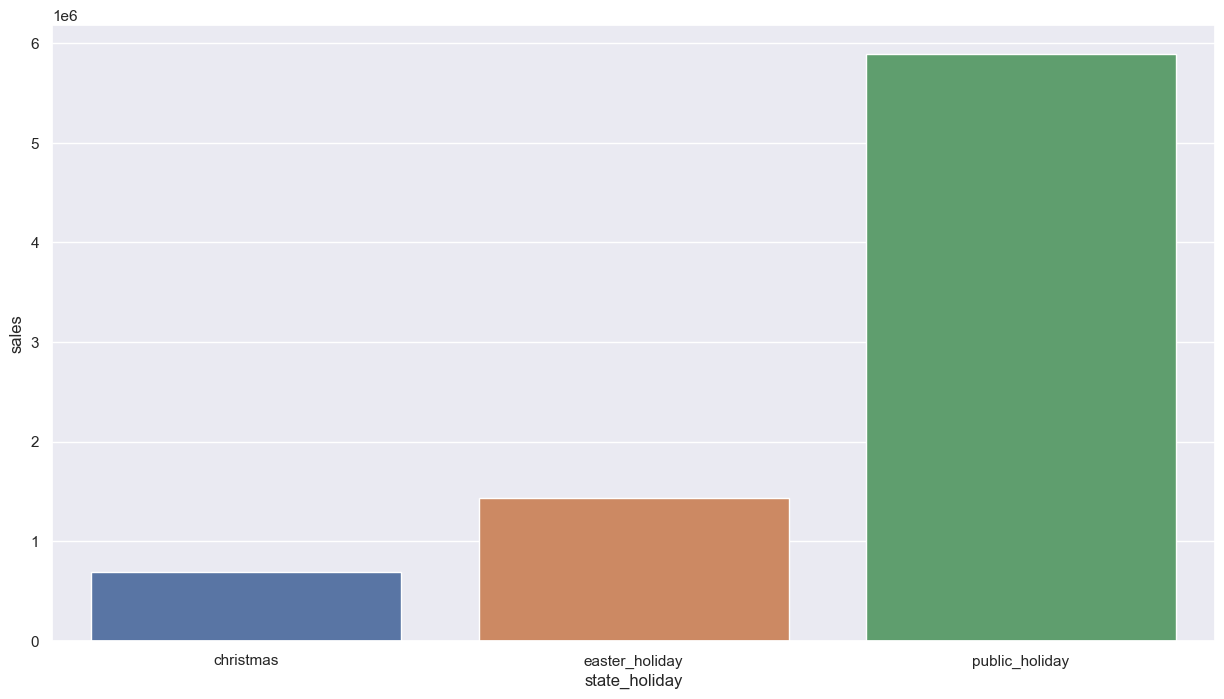

In [94]:
holiday_sales = df_aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=holiday_sales);

#### H7. Lojas vendem mais no segundo semestre do ano

**FALSA**: Excluindo as vendas feitas em 2015 (temos registros até agosto desse ano, prejudicando a análise de vendas no segundo semestre), as lojas vendem praticamente o mesmo no 1º e 2º semestre do ano. 

In [95]:
df_aux = df4[df4['year'] < 2015]

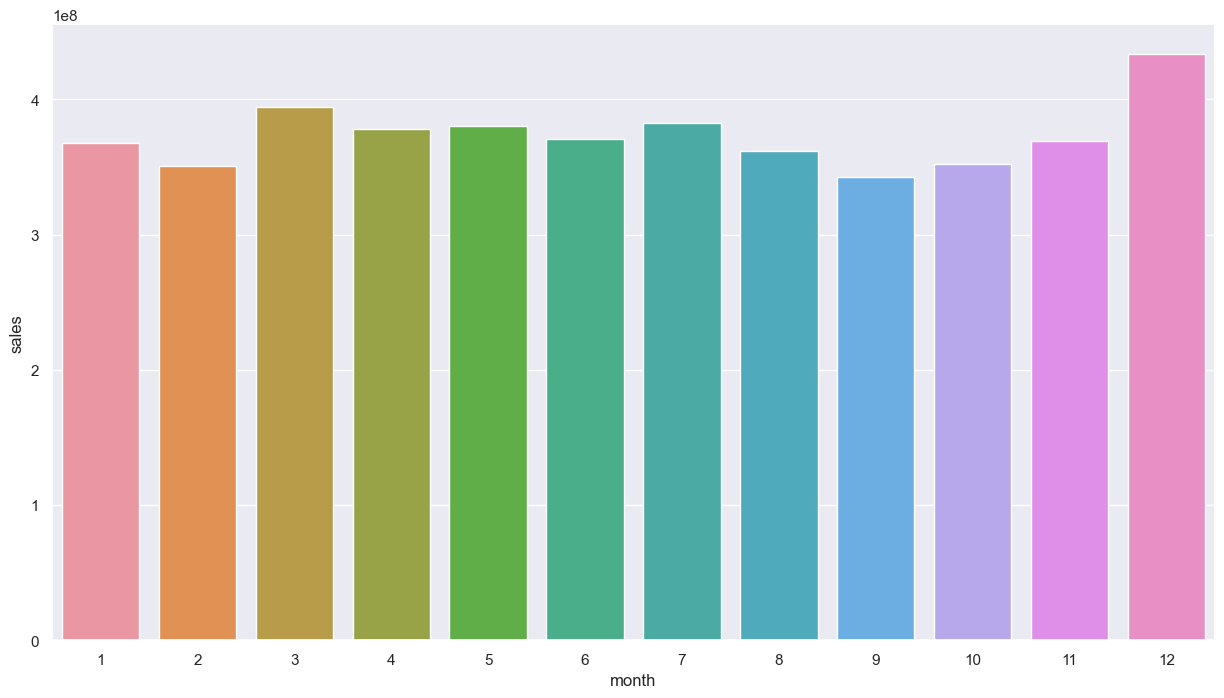

In [96]:
year_sales = df_aux[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=year_sales);

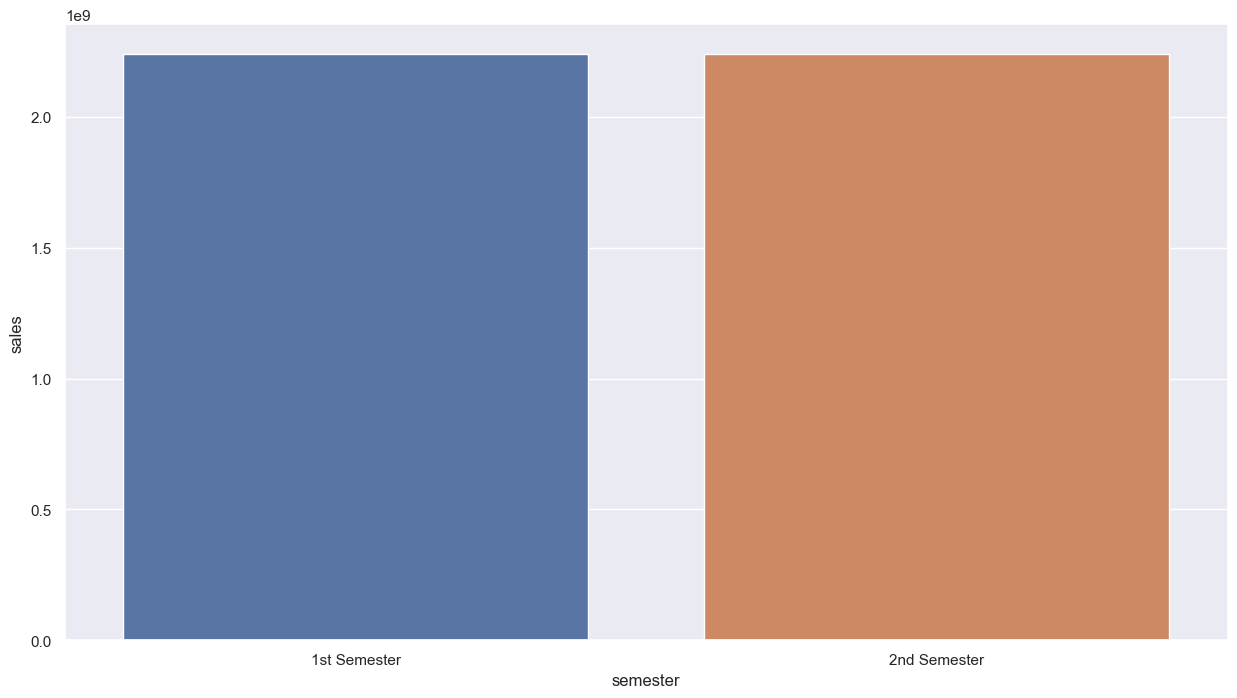

In [97]:
year_sales['semester'] = year_sales['month'].apply(lambda x: '1st Semester' if x <= 6 else '2nd Semester')
year_sales2 = year_sales[['semester', 'sales']].groupby('semester').sum().reset_index()
sns.barplot(x='semester', y='sales', data=year_sales2);

#### H8. Lojas vendem mais depois do dia 10 de cada mês

**VERDADEIRA**: Lojas vendem mais depois do 10 de cada mês, o que pode ser explicado pelo dobro da quantidade de dias nesse período (dias 11 até dia 31).

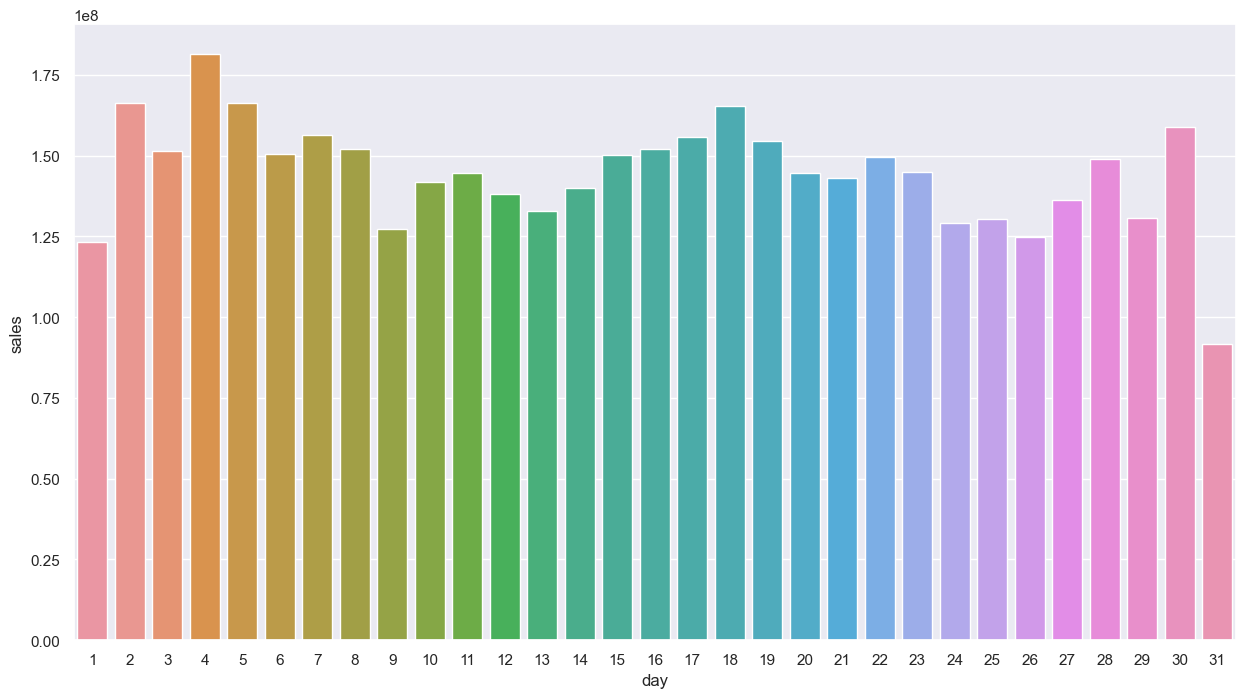

In [98]:
day_sales = df_aux[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=day_sales);

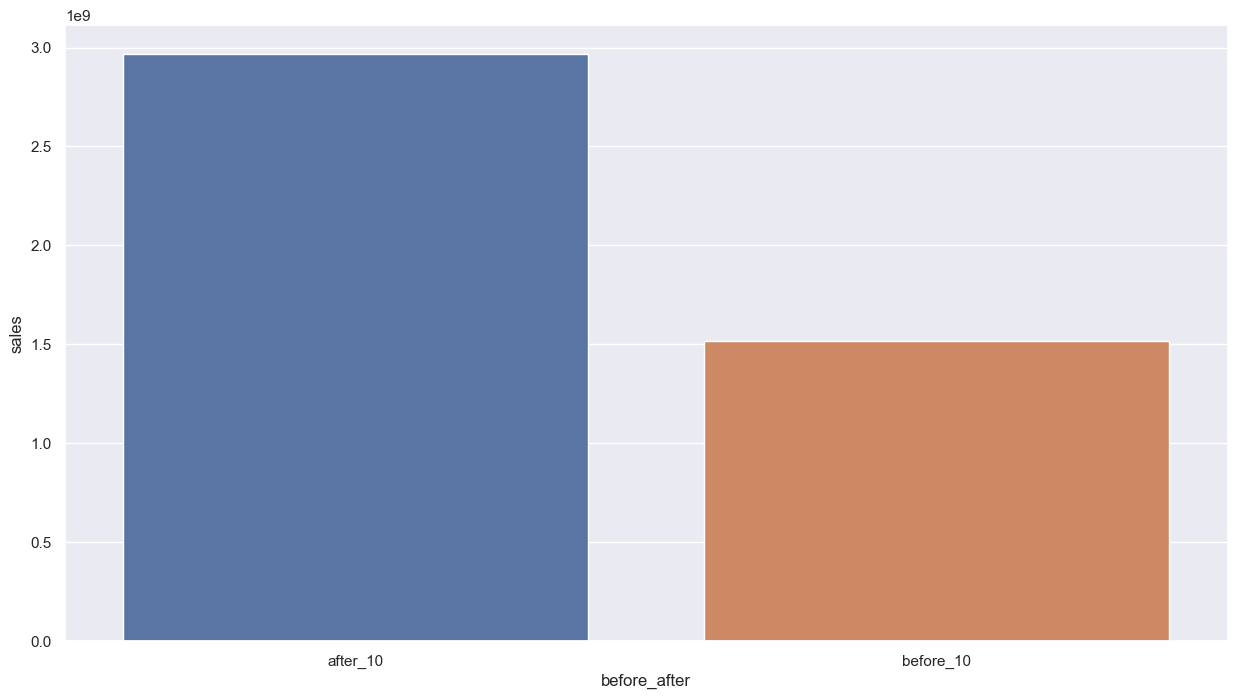

In [99]:
day_sales['before_after'] = day_sales['day'].apply(lambda x: 'before_10' if x <= 10 else 'after_10')
day_sales2 = day_sales[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=day_sales2);

#### H9. Lojas vendem menos durante feriados escolares

**VERDADEIRA**: Lojas vendem bem menos durante feriados escolares, exceto nos meses de Julho e Agosto (período de recesso escolar) dos anos observados.

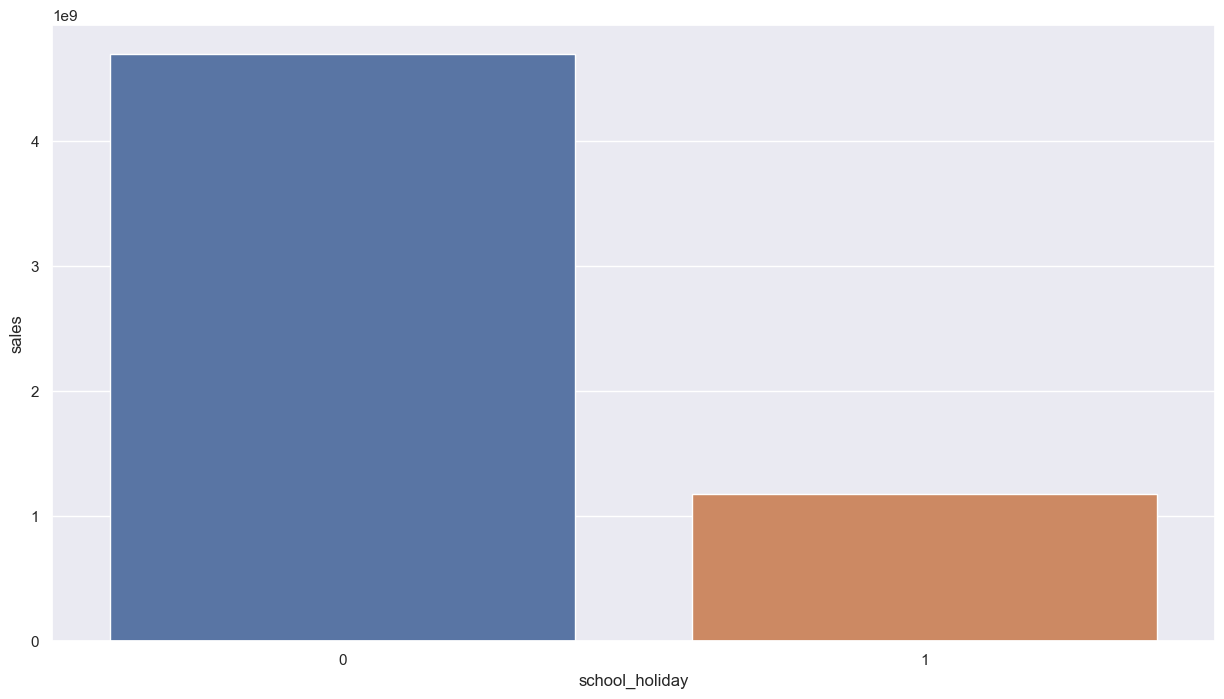

In [100]:
school_sales = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=school_sales);

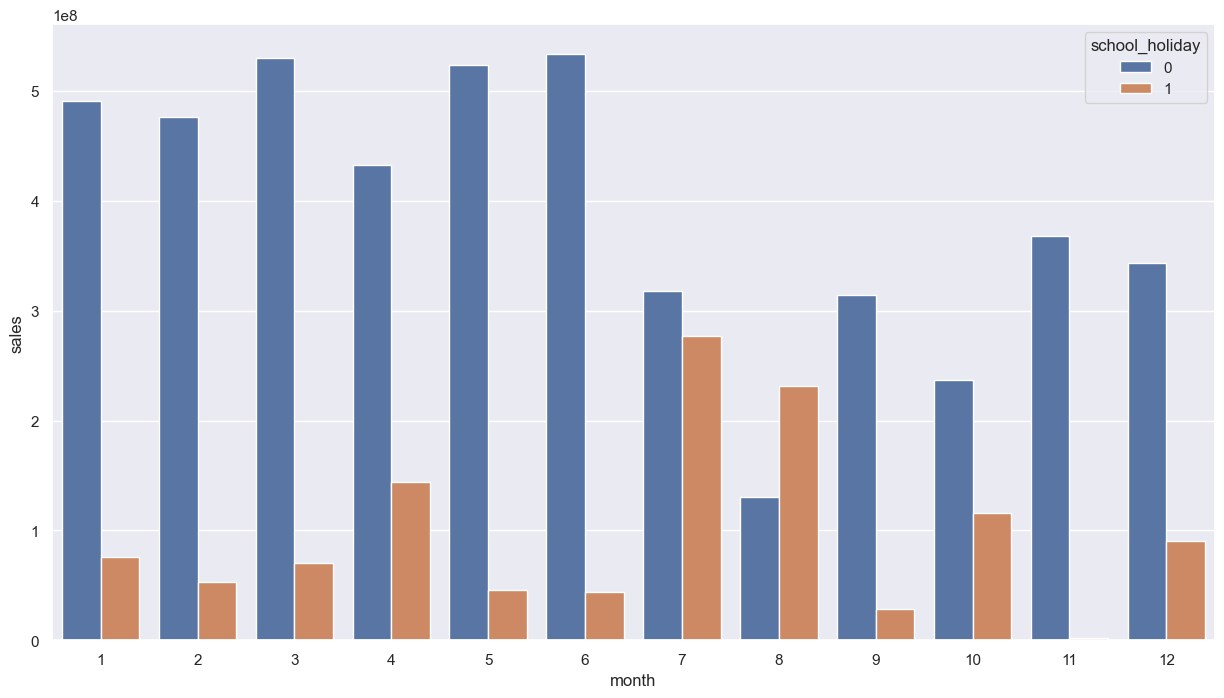

In [101]:
school_sales_month = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=school_sales_month);

#### Resumo das Hipóteses

|    Número      | Hipótese   | Conclusão |
| :------------: | :------:   | :-------: |
|       H1       | Lojas com maior sortimento (mix de produtos), na média, vendem mais | FALSA |
|       H2       | Lojas com competidores muito próximos vendem menos                  | FALSA |
|       H3       | Lojas com competidores a mais tempo vendem menos                    | VERDADEIRA |
|       H4       | Lojas com promoções ativas por mais tempo vendem mais               | FALSA |
|       H5       | Lojas com mais promoções consecutivas vendem mais                   | FALSA |
|       H6       | Lojas abertas durante o feriado de Natal vendem mais                | FALSA |
|       H7       | Lojas vendem mais no segundo semestre do ano                        | FALSA |
|       H8       | Lojas vendem mais depois do dia 10 de cada mês                      | VERDADEIRA |
|       H9       | Lojas vendem menos durante feriados escolares                       | VERDADEIRA |

### 5.3 Análise Multivariada

#### Variáveis Numéricas

In [102]:
df_numerical.head()

,day_of_week,sales,customers,competition_distance,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year
0,5,5263,555,1270.00,9,2008,31,2015
1,5,6064,625,570.00,11,2007,13,2010
2,5,8314,821,14130.00,12,2006,14,2011
3,5,13995,1498,620.00,9,2009,31,2015
4,5,4822,559,29910.00,4,2015,31,2015


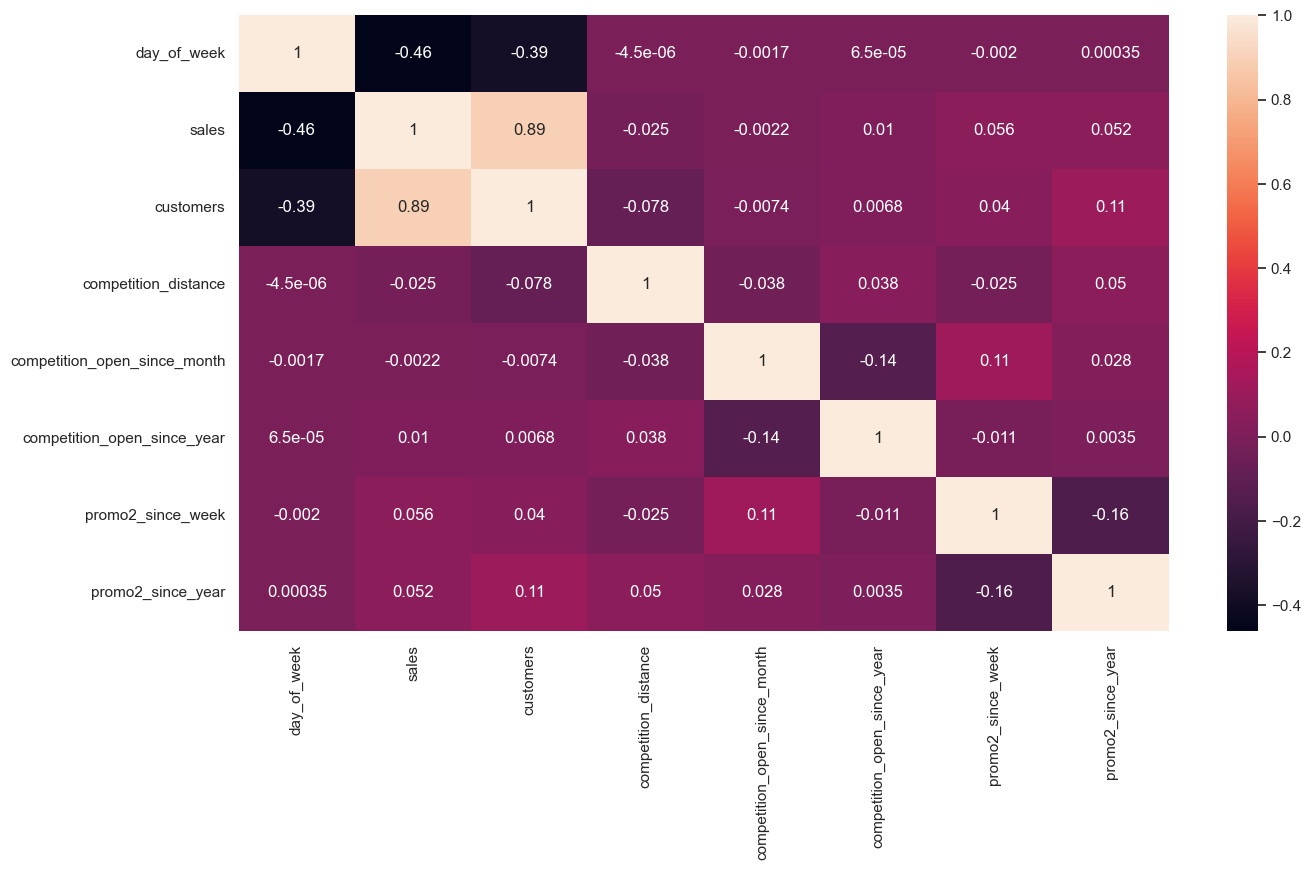

In [105]:
correlation = df_numerical.corr(method='pearson')
sns.heatmap(correlation, annot=True);

#### Variáveis Categóricas

In [106]:
df_categorical = df4.select_dtypes(include='object')
df_categorical.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [107]:
a1 = cramer_v(df_categorical['state_holiday'], df_categorical['state_holiday'])
a2 = cramer_v(df_categorical['state_holiday'], df_categorical['store_type'])
a3 = cramer_v(df_categorical['state_holiday'], df_categorical['assortment'])

a4 = cramer_v(df_categorical['store_type'], df_categorical['state_holiday'])
a5 = cramer_v(df_categorical['store_type'], df_categorical['store_type'])
a6 = cramer_v(df_categorical['store_type'], df_categorical['assortment'])

a7 = cramer_v(df_categorical['assortment'], df_categorical['state_holiday'])
a8 = cramer_v(df_categorical['assortment'], df_categorical['store_type'])
a9 = cramer_v(df_categorical['assortment'], df_categorical['assortment'])

df_corr = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})
df_corr = df_corr.set_index(df_corr.columns)
df_corr

,state_holiday,store_type,assortment
state_holiday,1.00,0.07,0.07
store_type,0.07,1.00,0.54
assortment,0.07,0.54,1.00


<AxesSubplot:>

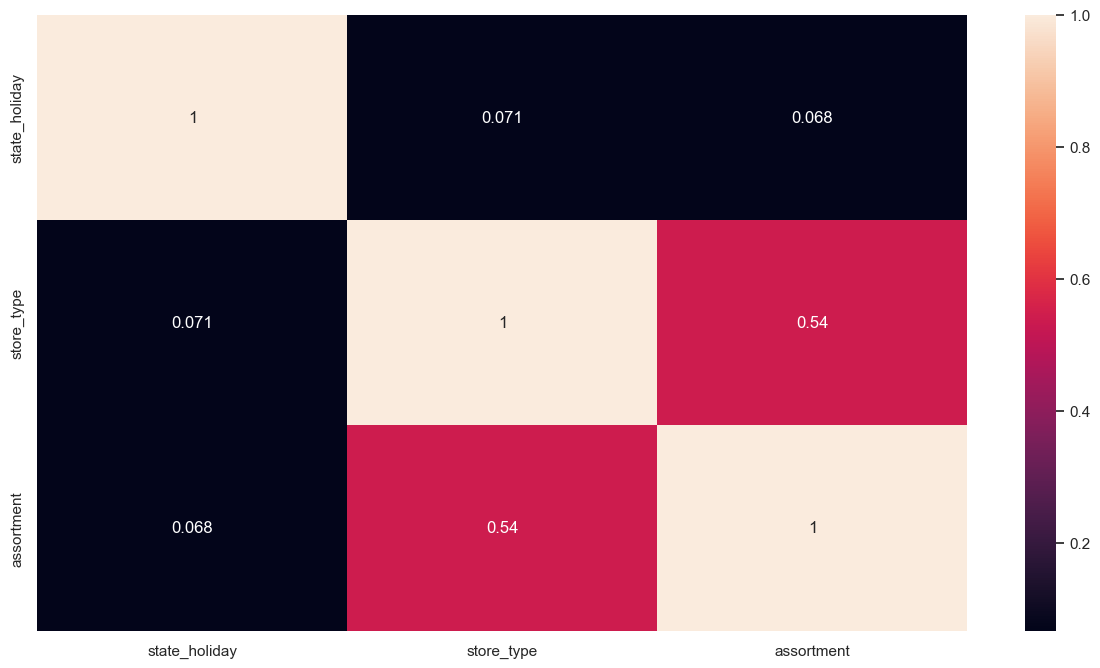

In [108]:
sns.heatmap(df_corr, annot=True)

## 6. Preparação dos Dados

In [59]:
df5 = df4.copy()

### 6.1 Normalização

Como não existem variáveis com distribuição normal, não vou usar a normalização para ajustar a escala dos dados.

### 6.2 *Rescaling*

Para as variáveis numéricas que são afetadas por outliers, irei utilizar o *Robust Scaler* para ajustar a escala dos dados. 

Já para as variáveis numéricas que não são tão afetadas por *outliers*, irei utilizar o *MinMax Scaler*. 

In [60]:
rs = RobustScaler()
mms = MinMaxScaler()

#### competition_distance

In [61]:
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameters/competition_distance_rescaler.pkl', 'wb'))

#### competition_open_time_month

In [62]:
df5['competition_open_time_month'] = rs.fit_transform(df5[['competition_open_time_month']].values)
pickle.dump(rs, open('parameters/competition_time_month_rescaler.pkl', 'wb'))

#### promo_since_week

In [63]:
df5['promo_since_week'] = mms.fit_transform(df5[['promo_since_week']].values)
pickle.dump(mms, open('parameters/promo_since_week_rescaler.pkl', 'wb'))

#### year

In [64]:
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameters/year_rescaler.pkl', 'wb'))

### 6.3 Transformação

#### 6.3.1 Encoding

Transformação das variáveis categóricas em variáveis numéricas.

##### state_holiday

Para essa variável, utilizarei o *One Hot Encoding*, que irá criar novas colunas para cada valor distinto da variável em questão.

In [65]:
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

##### store_type

Para essa variável, irei utilizar o *Label Encoding*, substituindo os valores categóricos por valores numéricos aleatórios.

In [66]:
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameters/store_type_encoder.pkl', 'wb'))

##### assortment

Para essa variável, irei utilizar o *Ordinal Encoding*, substituindo os valores categóricos por valores numéricos em uma ordem. 

In [67]:
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 6.3.2 Transformação de Grandeza - Variável Resposta

Usarei a transformação logarítmica para ajustar a escala dos valores da variável resposta *sales*.

In [68]:
df5['sales'] = np.log1p(df5['sales'])

#### 6.3.3 Transformação de Natureza

Algumas variáveis tem uma natureza cíclica, o que tem que ser levado em conta na hora da aplicação do algoritmo de *Machine Learning*.

##### day_of_week

In [69]:
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

##### day

In [70]:
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

##### week_of_year

In [71]:
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

##### month

In [72]:
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

## 7. Seleção de Variáveis (*Feature Selection*)

Para a Seleção de Variáveis vou usar o método de Seleção por Subset (*Wrapper Method*), através do algoritmo Boruta.

In [73]:
df6 = df5.copy()

### 7.1 Dividindo o Conjunto de Dados

Antes de dividir o conjunto de dados entre treino e teste, preciso remover algumas colunas que foram usadas para criar outras variáveis.

In [74]:
cols_to_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_open_since', 'year_week']

df6 = df6.drop(cols_to_drop, axis=1)

Como estou lidando com um problema temporal, não posso dividir aleatoriamente os dados entre treino e teste, assim tenho que dividir os dados levando em questão a data das vendas.

Para os dados de treino, vou pegar os registros desde a data mínima até 6 semanas antes da data máxima. 

Para os dados de teste, vou pegar os registros das últimas 6 semanas disponíveis.

In [75]:
print(df6['date'].min())
print(df6['date'].max())

2013-01-01 00:00:00
2015-07-31 00:00:00


In [76]:
df6['date'].max() - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

#### Conjunto de Dados de Treino

In [77]:
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

In [78]:
print('Data Mínima: {}'.format(X_train['date'].min()))
print('Data Máxima: {}'.format(X_train['date'].max()))

Data Mínima: 2013-01-01 00:00:00
Data Máxima: 2015-06-18 00:00:00


#### Conjunto de Dados de Teste

In [79]:
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

In [80]:
print('Data Mínima: {}'.format(X_test['date'].min()))
print('Data Máxima: {}'.format(X_test['date'].max()))

Data Mínima: 2015-06-19 00:00:00
Data Máxima: 2015-07-31 00:00:00


### 7.2 Usando Boruta para a Seleção de Variáveis

Para utilizarmos o Boruta, precisamos transformar o conjunto de dados de treino em vetores.

In [131]:
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
Y_train_n = Y_train.values.ravel()

O modelo que vou utilizar para a Seleção de Variáveis pelo Boruta será o *RandomForest*.

In [132]:
rf = RandomForestRegressor(n_jobs=-1)

Feito esses ajustes, irei executar o Boruta para verificar quais são as variáveis mais relevantes para a previsão dos valores de venda das lojas.

In [133]:
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 7.3 Variáveis Selecionadas pelo Boruta

Executado o Boruta, o algoritmo selecionou 18 variáveis como relevantes, e 9 como não relevantes.

Agora vou verificar quais variáveis foram selecionadas e quais não foram.

In [134]:
cols_selected = boruta.support_.tolist()

#### Variáveis Selecionadas

In [135]:
X_train_fs = X_train.drop(['date', 'sales'], axis=1)

cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_open_time_month',
 'promo_since_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'month_cos']

Para não ter que executar o Boruta toda vez para verificar as variáveis, vou criar uma cópia das que foram selecionadas (adicionei outras duas variáveis que julguei relevantes: *month_sin* e *week_of_year_sin*)

In [81]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_open_time_month',
 'promo_since_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin', # adicionei manualmente
 'week_of_year_cos',
 'month_sin', # adicionei manualmente
 'month_cos']

#### Variáveis não Selecionadas

In [137]:
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
cols_not_selected_boruta

['is_promo',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'year']

Da mesma forma que para as variáveis selecionadas, vou criar uma cópia das variáveis que não foram selecionadas.

In [82]:
cols_not_selected_boruta = [
 'is_promo',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'year']

## 8. Modelos de Machine Learning

Para fazer a previsão de vendas, vou utilizar 05 algoritmos de Machine Learning, comparando a performance de cada um posteriormente: 
- *Average Model*
- *Linear Regression*
- *Linear Regression Regularized*
- *Random Forest Regressor*
- *XGBoost Regressor*

Primeiro, vou criar um novo conjunto de dados somente com as variáveis selecionadas pelo Boruta.

In [83]:
x_train = X_train[cols_selected_boruta]
x_test  = X_test[cols_selected_boruta]

### 8.1 Média (*Average Model*)

Esse 'modelo' vai ser utilizado como métrica base de performance, para verificar se os modelos posteriores são melhores ou piores.

In [84]:
df_aux = x_test.copy()
df_aux['sales'] = Y_test.copy()
df_aux.sample(1)

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_open_time_month,promo_since_week,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,month_sin,month_cos,sales
47362,533,1,0,3,0.58,6,2015,0,25,2015,-0.22,0.29,-0.97,-0.22,-0.74,-0.67,0.12,-0.99,0.00,-1.00,9.39


#### Previsão

In [85]:
df_avg = df_aux[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
df_avg.head()

,store,predictions
0,1,8.37
1,2,8.46
2,3,8.80
3,4,9.19
4,5,8.35


In [86]:
df_aux2 = pd.merge(df_aux, df_avg, how='left', on='store')
df_aux2.sample(1)

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_open_time_month,promo_since_week,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,month_sin,month_cos,sales,predictions
23197,842,0,3,3,-0.18,11,2007,0,28,2015,1.04,0.29,0.43,-0.90,0.99,-0.10,-0.24,-0.97,-0.50,-0.87,9.99,9.91


Irei pegar somente o valor de previsão de vendas para verificação da performance.

In [87]:
yhat_baseline = df_aux2['predictions']

#### Performance

In [88]:
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.46,1835.14


### 8.2 Regressão Linear (*Linear Regression*)

#### Modelo

In [89]:
lr = LinearRegression().fit(x_train, Y_train)

#### Previsão

In [90]:
yhat_lr = lr.predict(x_test)

#### Performance

In [91]:
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.09,0.29,2671.05


### 8.3 Regressão Linear Regularizada (*Linear Regression Regularized - Lasso*)

#### Modelo

In [92]:
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

#### Previsão

In [93]:
yhat_lrr = lrr.predict(x_test)

#### Performance

In [94]:
lrr_result = ml_error('Linear Regression Regularized', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized,1891.70,0.29,2744.45


### 8.4 *Random Forest Regressor*

#### Modelo

In [95]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

#### Previsão

In [96]:
yhat_rf = rf.predict(x_test)

#### Performance

In [97]:
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.01,0.10,1011.71


### 8.5 *XGBoost Regressor*

#### Modelo

In [105]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators = 1000,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree=0.9).fit(x_train, Y_train)

#### Previsão

In [106]:
yhat_xgb = model_xgb.predict(x_test)

#### Performance

In [107]:
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,889.33,0.13,1312.66


### 8.6 Comparando a Performance dos Modelos

In [108]:
models_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
models_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.01,0.10,1011.71
0,XGBoost Regressor,889.33,0.13,1312.66
0,Average Model,1354.80,0.46,1835.14
0,Linear Regression,1867.09,0.29,2671.05
0,Linear Regression Regularized,1891.70,0.29,2744.45


Pelo fato do *Average Model* estar com uma performance melhor em relação aos modelos lineares (analisando o RMSE), conclui-se que o fenômeno de previsão de vendas não é um problema simples, mas sim um problema complexo que exige modelos mais complexos.

### 8.7 Cross-Validation

Para além do treino já feito, vou testar os algoritmos sobre outras fatias do conjunto de dados, para ter várias medições da performance dos diferentes modelos.

Fazendo a média dessas métricas de perfomance, teremos a performance real dos modelos.

#### Preparando o conjunto de dados

In [109]:
feats_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feats_to_add)

In [110]:
x_training = X_train[cols_selected_boruta_full]
x_training.sample(1)

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_open_time_month,promo_since_week,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,month_sin,month_cos,date,sales
124352,588,0,3,3,2.16,3,2010,0,15,2015,0.62,0.29,-0.78,0.62,0.74,-0.67,0.97,-0.24,0.87,-0.50,2015-04-11,8.42


#### Performance Real dos Modelos

##### 8.7.1 Regressão Linear (Linear Regression)

In [111]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


##### 8.7.2 Regressão Linear Regularizada (Linear Regression Regularized - Lasso)

In [112]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Regularized', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


##### 8.7.3 Random Forest Regressor

In [113]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.61 +/- 218.04,0.12 +/- 0.02,1256.51 +/- 319.05


##### 8.7.4 XGBoost Regressor

In [114]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1043.84 +/- 163.21,0.14 +/- 0.01,1506.73 +/- 221.11


#### Comparando a Performance Real dos Modelos

In [115]:
cv_models_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
cv_models_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression Regularized,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.61 +/- 218.04,0.12 +/- 0.02,1256.51 +/- 319.05
0,XGBoost Regressor,1043.84 +/- 163.21,0.14 +/- 0.01,1506.73 +/- 221.11


### 8.8 Performance sobre Teste *vs.* Cross-Validation

In [116]:
models_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.46,1835.14
0,Linear Regression,1867.09,0.29,2671.05
0,Linear Regression Regularized,1891.70,0.29,2744.45
0,Random Forest Regressor,680.01,0.10,1011.71
0,XGBoost Regressor,889.33,0.13,1312.66


In [117]:
cv_models_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression Regularized,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.61 +/- 218.04,0.12 +/- 0.02,1256.51 +/- 319.05
0,XGBoost Regressor,1043.84 +/- 163.21,0.14 +/- 0.01,1506.73 +/- 221.11


Analisando a métrica RMSE após o Cross-Validation, o modelo Random Forest apresentou a melhor performance.

Contudo, irei optar pelo o modelo XGBoost, haja vista a pouca diferença de performance e a questão de tamanho do arquivo para posterior implementação.

## 9. Hyperparemeter Fine Tunning

Vou adotar a estratégia de Random Search para realizar o Fine Tunning, vez que é mais simples e rápida de ser aplicada.

### 9.1 Random Search

Primeiro vou criar um dicionário com os parâmetros e alguns valores aleatórios, bem como definir quantas combinações de valores serão feitas.

In [145]:
param = {'n_estimators': [1000, 1220, 1300, 1450, 1580],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}

max_iterations = 5

Agora é criar um loop for para realizar o treinamento do algoritmo com base nas combinações de valores aleatórias.

In [147]:
final_result = pd.DataFrame()

for i in range(max_iterations):
    
    # Escolhendo o conjunto de valores aleatoriamente
    hp = {k: random.choice(v,1)[0] for k, v in param.items()}
    print(hp)

    # Criando o modelo    
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators = hp['n_estimators'],
                                   eta = hp['eta'],
                                   max_depth = hp['max_depth'],
                                   subsample = hp['subsample'],
                                   colsample_bytree = hp['colsample_bytree'],
                                   min_child_weight = hp['min_child_weight'])
    
    # Verificando a perfomance com Cross-Validation
    result = cross_validation(x_training, 5, 'XGBoost Regressor',  model_xgb)
    
    # Criando o dataframe para comparação de métricas de performance
    final_result = pd.concat([final_result, result])

{'n_estimators': 1450, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 1220, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1300, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1300, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 1000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}


Feito isso, é só comparar as métricas e escolher o conjunto de valores com menor erro.

In [148]:
final_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1799.18 +/- 194.07,0.25 +/- 0.01,2577.59 +/- 264.68
0,XGBoost Regressor,1275.51 +/- 134.76,0.18 +/- 0.01,1839.5 +/- 183.16
0,XGBoost Regressor,1040.57 +/- 165.56,0.14 +/- 0.01,1506.36 +/- 229.82
0,XGBoost Regressor,1555.7 +/- 172.6,0.22 +/- 0.01,2245.86 +/- 232.61
0,XGBoost Regressor,1688.27 +/- 180.46,0.24 +/- 0.01,2427.07 +/- 237.41


### 9.2 Modelo Final

#### Parâmetros

In [149]:
param_tuned = {'n_estimators': 1300, 
               'eta': 0.01,
               'max_depth': 9,
               'subsample': 0.1,
               'colsample_bytree': 0.7,
               'min_child_weight': 15}

#### Modelo

In [150]:
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators = param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree = param_tuned['colsample_bytree'],
                                   min_child_weight = param_tuned['min_child_weight']).fit(x_train, Y_train)

#### Previsão

In [151]:
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#### Performance

In [152]:
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,881.45,0.13,1283.47


Verificando o MPE do modelo:

In [153]:
mpe = mean_percentage_error(np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.014364160386922188

## 10. Interpretação e Tradução do Erro

Criando o conjunto de dados final com as previsões de venda feitas pelo modelo:

In [154]:
df9 = X_test[cols_selected_boruta_full].copy()
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

df9.sample(1)

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_open_time_month,promo_since_week,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,month_sin,month_cos,date,sales,predictions
5357,898,1,0,1,2.61,7,2015,0,31,2015,-0.22,0.29,0.78,0.62,-0.59,0.81,-0.57,-0.82,-0.50,-0.87,2015-07-27,10350.00,9356.51


### 10.1 Performance do Negócio

#### Previsão de Venda por Loja

In [155]:
df_sum = df9[['store', 'predictions']].groupby('store').sum().reset_index()
df_sum.head()

,store,predictions
0,1,174484.73
1,2,185132.41
2,3,255490.67
3,4,329700.75
4,5,173620.06


#### MAE e MAPE por Loja

In [156]:
df_mae = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df_mape = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})
df_mae_mape = pd.merge(df_mae, df_mape, how='inner', on='store')
df_mae_mape.head()

,store,MAE,MAPE
0,1,397.87,0.09
1,2,503.14,0.10
2,3,538.52,0.07
3,4,1131.04,0.11
4,5,415.41,0.10


#### Previsão, MAE, e MAPE por Loja

In [157]:
df_final = pd.merge(df_sum, df_mae_mape, how='inner', on='store')
df_final.head()

,store,predictions,MAE,MAPE
0,1,174484.73,397.87,0.09
1,2,185132.41,503.14,0.10
2,3,255490.67,538.52,0.07
3,4,329700.75,1131.04,0.11
4,5,173620.06,415.41,0.10


#### Usando o MAE para projetar Cenários

In [158]:
df_final['worst_scenario'] = df_final['predictions'] - df_final['MAE']
df_final['best_scenario']  = df_final['predictions'] + df_final['MAE']
df_final = df_final[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
df_final.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,174484.73,174086.86,174882.61,397.87,0.09
1,2,185132.41,184629.27,185635.54,503.14,0.10
2,3,255490.67,254952.16,256029.19,538.52,0.07
3,4,329700.75,328569.71,330831.79,1131.04,0.11
4,5,173620.06,173204.65,174035.47,415.41,0.10


#### Verificando o MAPE por Loja

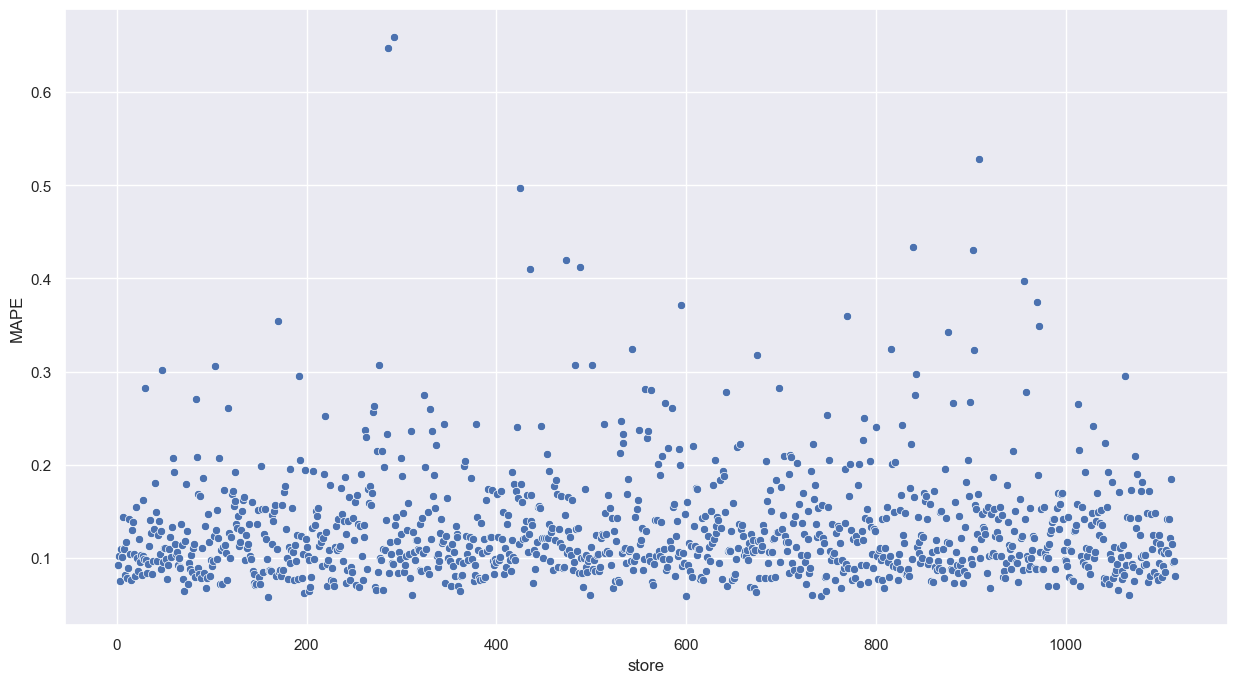

In [159]:
sns.scatterplot(x='store', y='MAPE', data=df_final);

### 10.2 Performance Total

In [160]:
df_total = df_final[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns={'index': 'Scenarios', 0:'Sales'})
df_total

,Scenarios,Sales
0,predictions,281083520.00
1,worst_scenario,280098063.27
2,best_scenario,282068968.59


### 10.3 Performance do Modelo

In [161]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

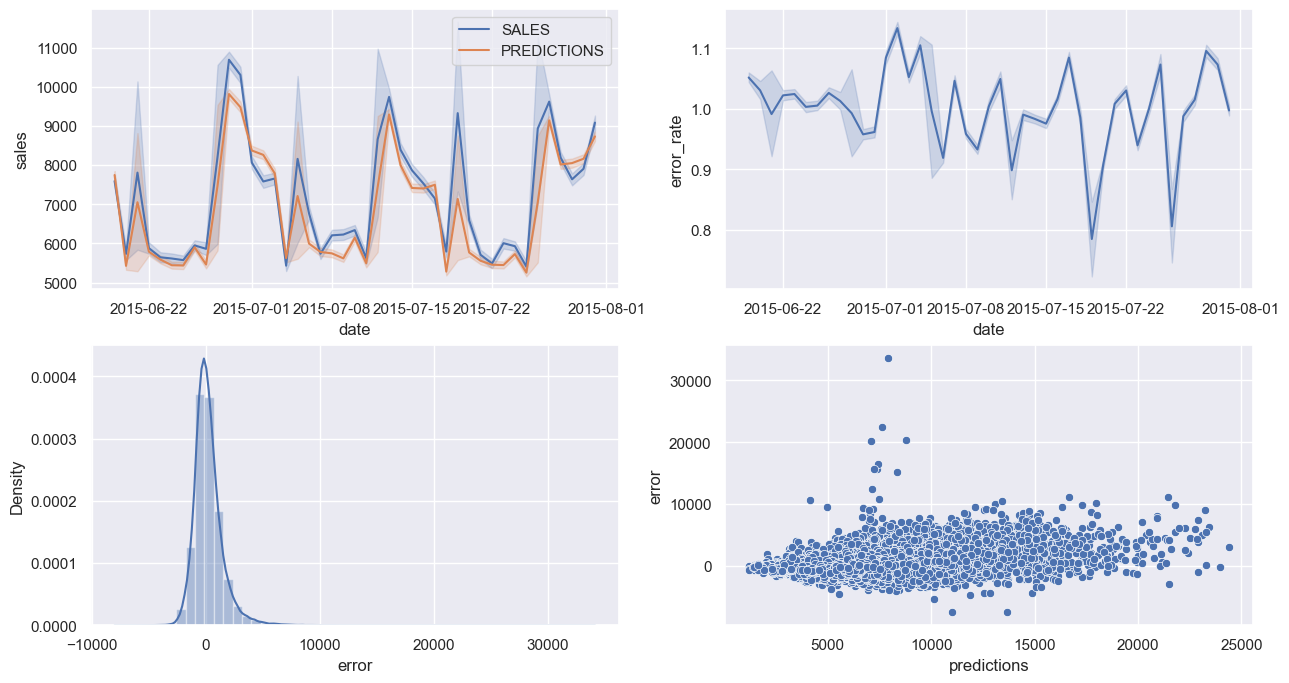

In [162]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df9);

## 11. Modelo em Produção

Feito o *fine tunning* e avaliado o modelo, vou salvá-lo para implementação.

In [164]:
pickle.dump(model_xgb_tuned, open('model/model_rossmann.pkl', 'wb'))

### 11.1 Classe Rossmann

Vou criar uma classe com alguns métodos para efetuar a limpeza e preparação dos dados, para ser utilizada posteriormente pela API. 

In [165]:
import math
import pickle
import datetime
import inflection
import numpy  as np
import pandas as pd

class Rossmann(object):
    
    def __init__(self):
        self.home_path = 'C:/Users/Nicolas/repos/comunidade_DS/ds_em_producao/'
        self.competition_distance_rescaler   = pickle.load(open(self.home_path + 'parameters/competition_distance_rescaler.pkl', 'rb'))
        self.competition_time_month_rescaler = pickle.load(open(self.home_path + 'parameters/competition_time_month_rescaler.pkl', 'rb'))
        self.promo_since_week_rescaler       = pickle.load(open(self.home_path + 'parameters/promo_since_week_rescaler.pkl', 'rb'))
        self.year_rescaler                   = pickle.load(open(self.home_path + 'parameters/year_rescaler.pkl', 'rb'))
        self.store_type_encoder              = pickle.load(open(self.home_path + 'parameters/store_type_encoder.pkl', 'rb'))
      
        
    def data_cleaning(self, df1):

        # Renomeando Colunas
        old_cols = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        to_snakecase = lambda x: inflection.underscore(x)

        new_cols = list(map(to_snakecase, old_cols))

        df1.columns = new_cols
        
        # Alterando Tipos de Dados
        df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d')

        # Preenchendo Valores Nulos
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

        months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 7: 'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['promo_interval'] = df1['promo_interval'].fillna(0)

        df1['month'] = df1['date'].dt.month.map(months)

        df1['is_promo'] = df1[['promo_interval', 'month']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month'] in x['promo_interval'].split(',') else 0, axis = 1)
        
        # Alterando Tipos de Dados após Preenchimento de Valores Nulos
        
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        
        df1['competition_open_since_year']  = df1['competition_open_since_year'].astype('int64')
        
        df1['promo2_since_week']            = df1['promo2_since_week'].astype('int64')
        
        df1['promo2_since_year']            = df1['promo2_since_year'].astype('int64')
        
        return df1
    
    
    def feature_engineering(self, df2):
        
        df2['year'] = df2['date'].dt.year

        df2['month'] = df2['date'].dt.month

        df2['day'] = df2['date'].dt.day

        df2['week_of_year'] = df2['date'].dt.weekofyear

        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        df2['competition_open_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

        df2['competition_open_time_month'] = ((df2['date'] - df2['competition_open_since']) / 30).apply(lambda x: x.days).astype(int)

        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

        df2['promo_since_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
        
        return df2
    
    
    def data_filter(self, df3):
        
        df3 = df3[df3['open'] != 0]
        
        cols_to_drop = ['open', 'promo_interval']
        df3 = df3.drop(cols_to_drop, axis = 1)
        
        return df3
    
    
    def data_preparation(self, df5):
        
        # Rescaling
        df5['competition_distance'] = self.competition_distance_rescaler.transform(df5[['competition_distance']].values)
        df5['competition_open_time_month'] = self.competition_time_month_rescaler.transform(df5[['competition_open_time_month']].values)
        df5['promo_since_week'] = self.promo_since_week_rescaler.transform(df5[['promo_since_week']].values)
        df5['year'] = self.year_rescaler.transform(df5[['year']].values)
        
        # Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
        df5['store_type'] = self.store_type_encoder.fit_transform(df5['store_type'])
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        # Transformação de Natureza  
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))
        
        # Seleção de Variáveis
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                          'competition_open_since_year', 'promo2', 'promo2_since_week',  'promo2_since_year', 'competition_open_time_month',
                          'promo_since_week', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos',
                          'month_sin', 'month_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        
        # Previsões
        pred = model.predict(test_data)
        
        # Juntar as previsões no conjunto de dados
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

### 11.2 API Handler

Criação da API para realizar a consulta de previsão de vendas por loja através de qualquer dispositivo.

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Carregando o modelo de ML
model = pickle.load(open('C:/Users/Nicolas/repos/comunidade_DS/ds_em_producao_v2/model/model_rossmann.pkl', 'rb'))

# Inicializando a API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # Caso existam dados
        
        if isinstance(test_json, dict): # Um registro
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # Múltiplos registros
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
        
        # Instanciando a classe Rossmann
        pipeline = Rossmann()
        
        # Limpeza e Preparação dos dados
        df1 = pipeline.data_cleaning(test_raw)
        df2 = pipeline.feature_engineering(df1)
        df3 = pipeline.data_filter(df2)
        df4 = pipeline.data_preparation(df3)
        
        # Previsão
        df_response = pipeline.get_prediction(model, test_raw, df4)
        
        return df_response        
        
    else: # Caso não existam dados
        return Response('{}', status=200, mimetype='application/json')

        
if __name__ == '__main__':
    app.run('192.168.100.12')

### 11.3 API Tester

Teste de requisição na API após publicação do *Handler*.

In [205]:
df10 = pd.read_csv('csv/test.csv', low_memory=False)
df10.sample(4)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
27660,27661,347,7,2015-08-16,0.00,0,0,0
11113,11114,1099,6,2015-09-05,1.00,0,0,0
35160,35161,83,5,2015-08-07,1.00,1,0,1
25506,25507,885,3,2015-08-19,1.00,1,0,0


In [206]:
df_test = pd.merge(df10, df_stores_raw, how='left', on='Store')
df_test.sample(1)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
15472,15473,83,7,2015-08-30,0.00,0,0,0,a,a,2710.00,NaN,NaN,0,NaN,NaN,NaN


In [207]:
df_test = df_test[df_test['Store'].isin([973, 1114, 678, 1113])]
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [208]:
data = json.dumps(df_test.to_dict(orient='records'))

In [209]:
import requests

#url = 'http://192.168.100.12:5000/rossmann/predict'
url = 'https://test-rossmann.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code: {}'.format(r.status_code))

Status Code: 200


In [210]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month,is_promo,year,day,week_of_year,year_week,competition_open_since,competition_open_time_month,promo_since,promo_since_week,prediction
0,678,4,2015-09-17T00:00:00.000Z,1.00,1,regular_day,0,c,basic,3250.00,9,2015,1,40,2011,"Jan,Apr,Jul,Oct",9,0,2015,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2011-09-26T00:00:00.000Z,207,6883.68
1,973,4,2015-09-17T00:00:00.000Z,1.00,1,regular_day,0,d,extended,330.00,9,2015,1,28,2012,"Jan,Apr,Jul,Oct",9,0,2015,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-07-02T00:00:00.000Z,167,7369.30
2,1113,4,2015-09-17T00:00:00.000Z,1.00,1,regular_day,0,a,extended,9260.00,9,2015,0,38,2015,0,9,0,2015,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2015-09-14T00:00:00.000Z,0,6907.48
3,1114,4,2015-09-17T00:00:00.000Z,1.00,1,regular_day,0,a,extended,870.00,9,2015,0,38,2015,0,9,0,2015,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2015-09-14T00:00:00.000Z,0,20200.29
4,678,3,2015-09-16T00:00:00.000Z,1.00,1,regular_day,0,c,basic,3250.00,9,2015,1,40,2011,"Jan,Apr,Jul,Oct",9,0,2015,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2011-09-26T00:00:00.000Z,207,6875.57


In [211]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('A loja número {} vai vender {:.2f} nas próximas 06 semanas.'.format(
    d2.loc[i, 'store'],
    d2.loc[i, 'prediction']))

A loja número 678 vai vender 265589.63 nas próximas 06 semanas.
A loja número 973 vai vender 301290.20 nas próximas 06 semanas.
A loja número 1113 vai vender 269100.46 nas próximas 06 semanas.
A loja número 1114 vai vender 859726.47 nas próximas 06 semanas.
